In [12]:
import ssdeep
import pickle,os,sys,gc
import pandas as pd
# pd.set_option('display.max_columns', None)
import numpy as np
from tqdm import tqdm
from collections import Counter
import multiprocessing as mp
from multiprocessing import Process, Manager, Pool
import time,datetime
from itertools import chain
import math
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
import functools
import itertools
import operator
from itertools import chain
sys.setrecursionlimit(1000000)

### Function

In [9]:
isp = '台灣固網'
time_li = ['20200106','20200107','20200108','20200109','20200110','20200111','20200112']
time = str(min(time_li))
picture_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(time[:4])+'_'+str(time[4:6])+'_'+str(time[6:])+'/'+isp+'/case_pictures/'


合併三個dict用update來合併以後再通過後面的df function畫圖

In [13]:

def cluster_rep_hash(proto_big_dict,proto_df_payload,proto_df,proto_loners,knee_point,date='0110',protocol='http'):
    '''
    GOAL: create each cluster's representaion ssdeep hash
    proto_df_payload: from prepare_df() function
    proto_big_dict: from similarity_compare() function
    proto_loners: loner idx list
    knee_point: from get_small_cluster() function
    date & protocol: user_defined cluster name
    
    Return: dict[cluster_name]: ssdeep hash
    '''
    upgma_dict = {}
    for key,value in proto_big_dict.items(): #cluster rep ssdeep
        target = proto_df_payload[proto_df_payload.idx == key]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q2 = int(t_len*0.5)
        q2_hash = target.iloc[q2,-1]
        country = proto_df.loc[key,'country']
        ip = proto_df.loc[key,'ip_src']
        domain = proto_df.loc[key,'domain']
        if len(value)>knee_point:
            upgma_dict[str(protocol)+'_'+str(key)+'_'+str(date)+'_'+str(country)+'_'+str(domain)+'_'+str(ip)] = q2_hash
        else:
            upgma_dict[str(protocol)+'_S_'+str(key)+'_'+str(date)+'_'+str(country)+'_'+str(domain)+'_'+str(ip)] = q2_hash
    for key in proto_loners: #loner ssdeep
        target = proto_df_payload[proto_df_payload.idx == key]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q2 = int(t_len*0.5)
        q2_hash = target.iloc[q2,-1]
        country = proto_df.loc[key,'country']
        ip = proto_df.loc[key,'ip_src']
        domain = proto_df.loc[key,'domain']
        upgma_dict[str(protocol)+'_L_'+str(key)+'_'+str(date)+'_'+str(country)+'_'+str(domain)+'_'+str(ip)] = q2_hash
    return upgma_dict



def pair_wise_score(upgma_dict):
    '''
    GOAL: calculate distance matrix by calculating paire-wise similarity score. 
    and pick upper triangle convert to list
    Input: from cluster_rep_hash() function
    ['cluster']: name
    ['ssdeep']: cluster's representation hash
    
    Return: df=>['c_ssdeep_li']:the hashes list compare to, ['score']:list of distances (upper-triangle, exclude self)
    '''
    def compare(target_hash,candidate_hash_li):
        score_li = []
        for c_hash in candidate_hash_li:
            score_li.append(100-ssdeep.compare(target_hash,c_hash)) #相似度滿分100，轉換成距離最近0
        return score_li
    used_idx = []
    def create_hash_li(t_hash):
        idx_set = set(upgma_df[upgma_df.ssdeep == t_hash].index)#[0]
        same_hash_li = sorted(list(idx_set - set(used_idx)))
        idx = same_hash_li[0]
        used_idx.append(idx)
        return upgma_df.loc[idx+1:]['ssdeep'].tolist()
    upgma_df = pd.DataFrame(upgma_dict.items(),columns=['cluster','ssdeep'])
    upgma_df['c_ssdeep_li'] = upgma_df.ssdeep.map(create_hash_li)
    upgma_df['score'] = upgma_df.apply(lambda x: compare(x.ssdeep, x.c_ssdeep_li), axis=1)
    return upgma_df



def draw_upgma(upgma_df,picture_dir=picture_dir,name='upgma'):
    '''
    GOAL: using upper triangle's distance to draw upgma
    Input: from pair_wise_score() function
    Output: diagram of UPGMA、Z info
    '''
    if not os.path.exists(picture_dir):
        os.makedirs(picture_dir,exist_ok=True) 
    score_li = upgma_df['score'].tolist()
    score_li = list(filter(None, score_li))
    score_li = sum(score_li,[])
    Z = linkage(score_li, 'average')
    fig = plt.figure(figsize=(60, 24)) #(25,10) #(5,2)
    # plt.savefig(fig)
    dn = dendrogram(Z,labels=upgma_df.cluster.tolist())
    plt.savefig(picture_dir+str(name)+'.png', dpi=600, format='png', bbox_inches='tight')
    return dn,Z

{'sip_L_824633725480_20200107_United States_None_156.239.157.86': '3:OXXUD8EU1V1V1V1RYP/LfIQfdplr+Mfjfun:O0DVPxdL+Mfjmn',
 'sip_S_94489305705_20200108_France_ip-5-135-73.eu_5.135.73.105': '24:p2kQ17mDETU7ft9ckQFAOckQFA+UDR0dSRtPKiRvb3Za7gcXYEXl8XYQcs:EAaO1ShEhH2Nj07LI08oo',
 'sip_L_472446424832_20200108_Russia_None_185.156.177.70': '3:OXXXL1Vf1V1V1V1RYP/LfIQfdplr+M5DcEYVV91v/vV1V1VV:OQPxdL+M5Avf9',
 'sip_S_4371_20200110_United States_None_170.130.187.30': '24:qgOf3vI7mDL5gizTKiqf3vX4v/DRt0UUgbYMfy1wUX18YHWN:ANLjcv4vmg/A18VN',
 'sip_L_274877921633_20200110_China_None_61.187.195.129': '3:OXXUD8EU1V1V1V1RYP/LfIQfdplr+Mfjfun:O0DVPxdL+Mfjmn'}

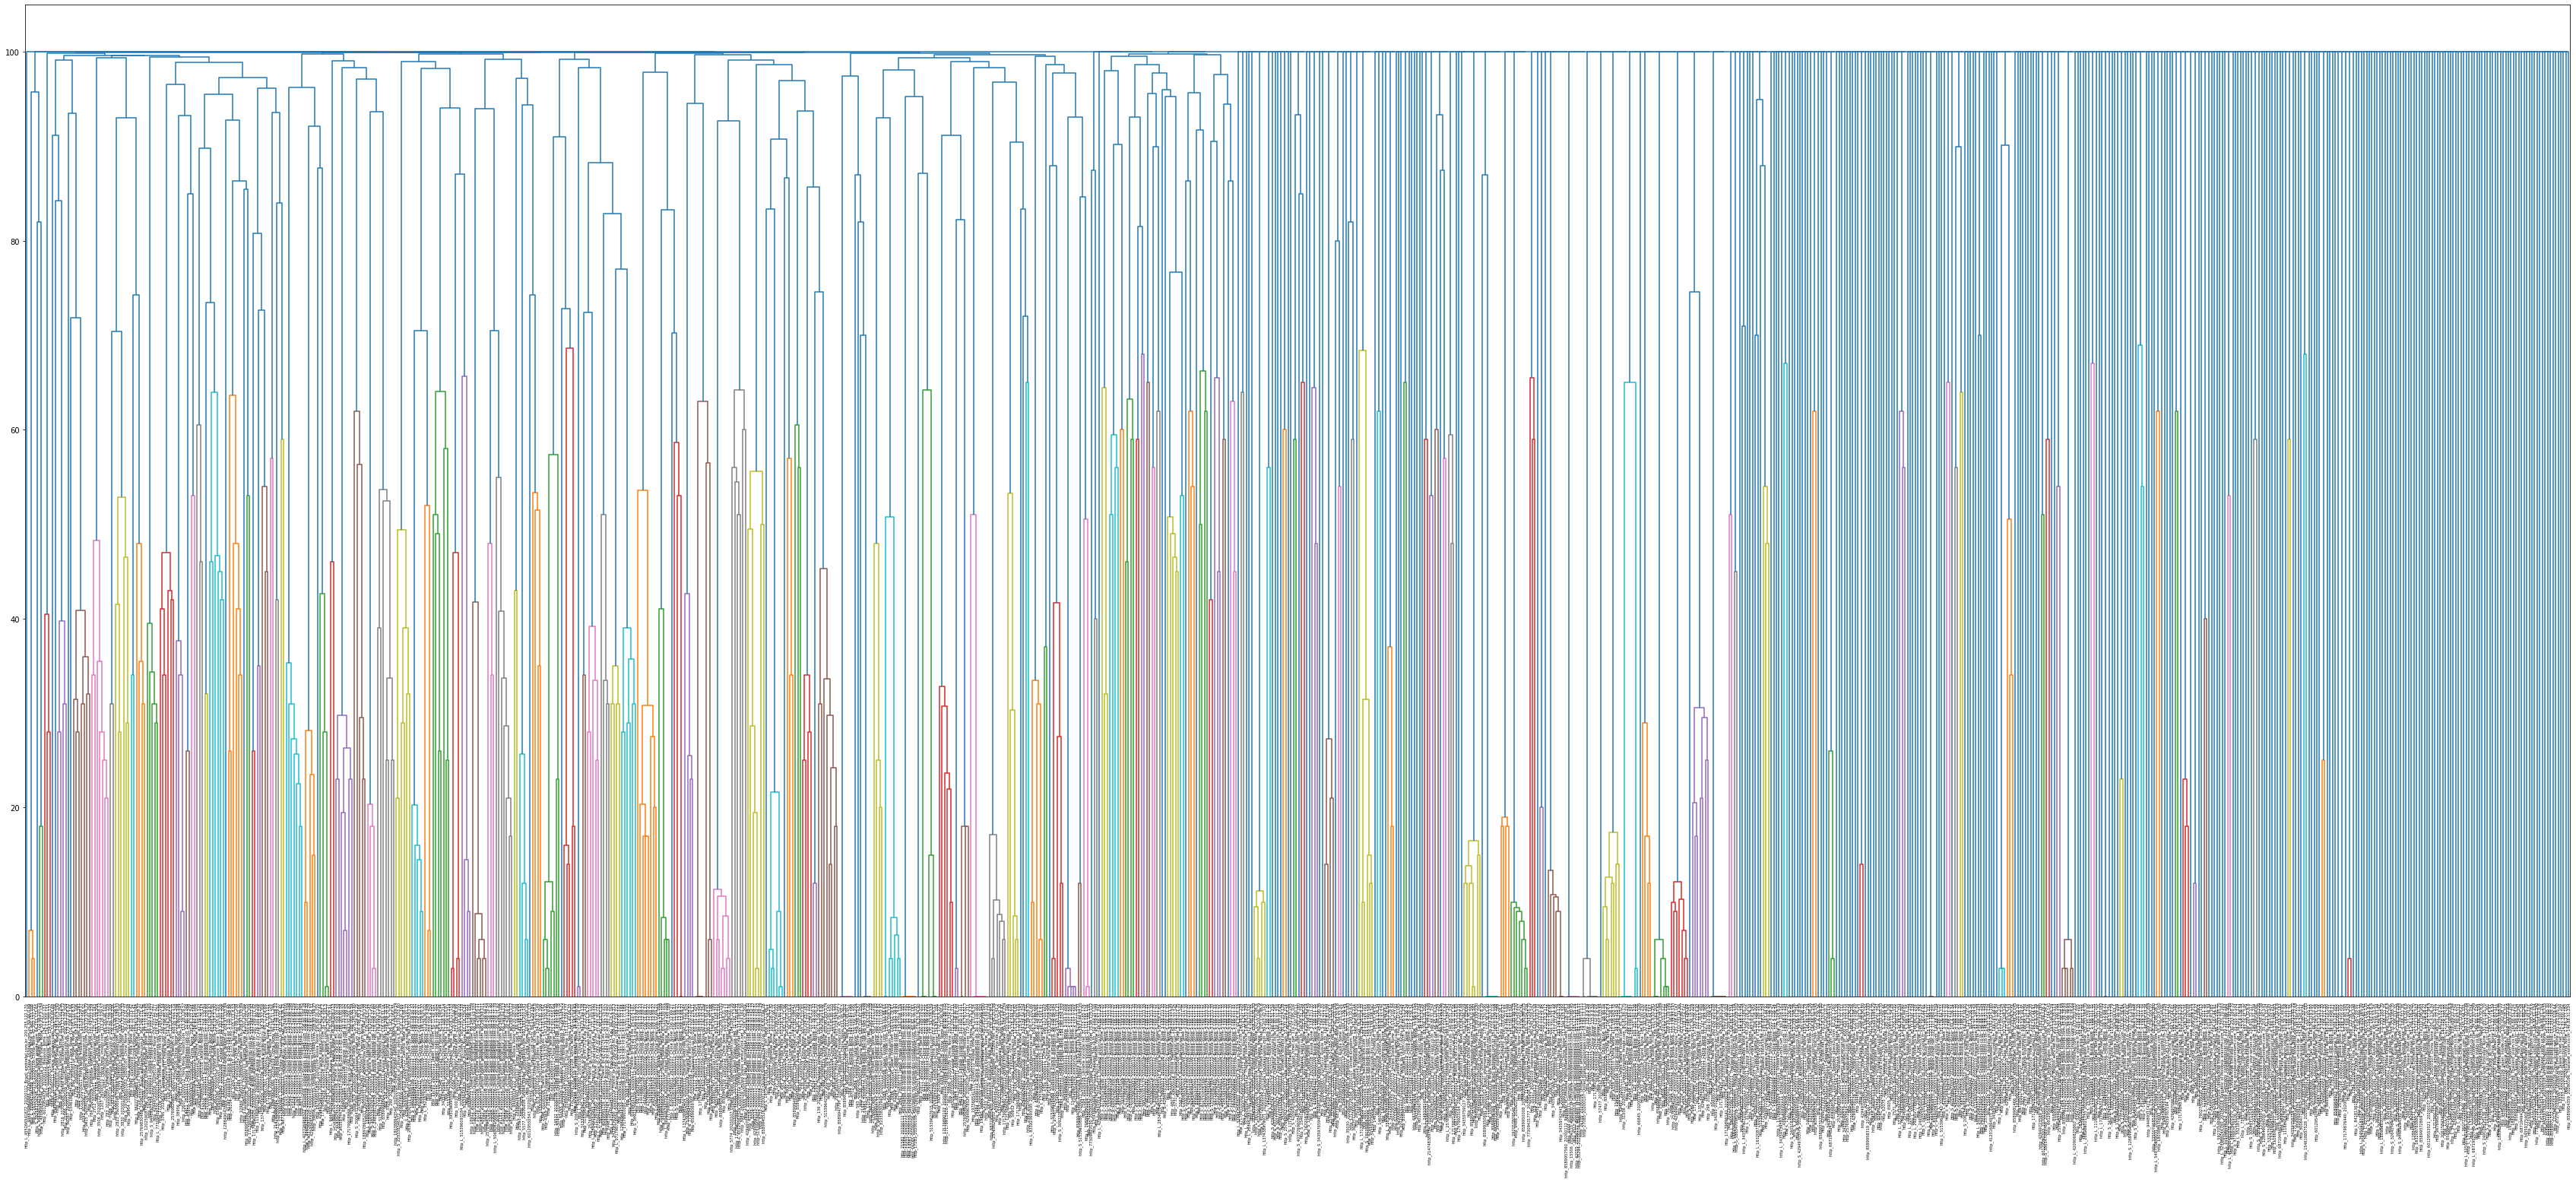

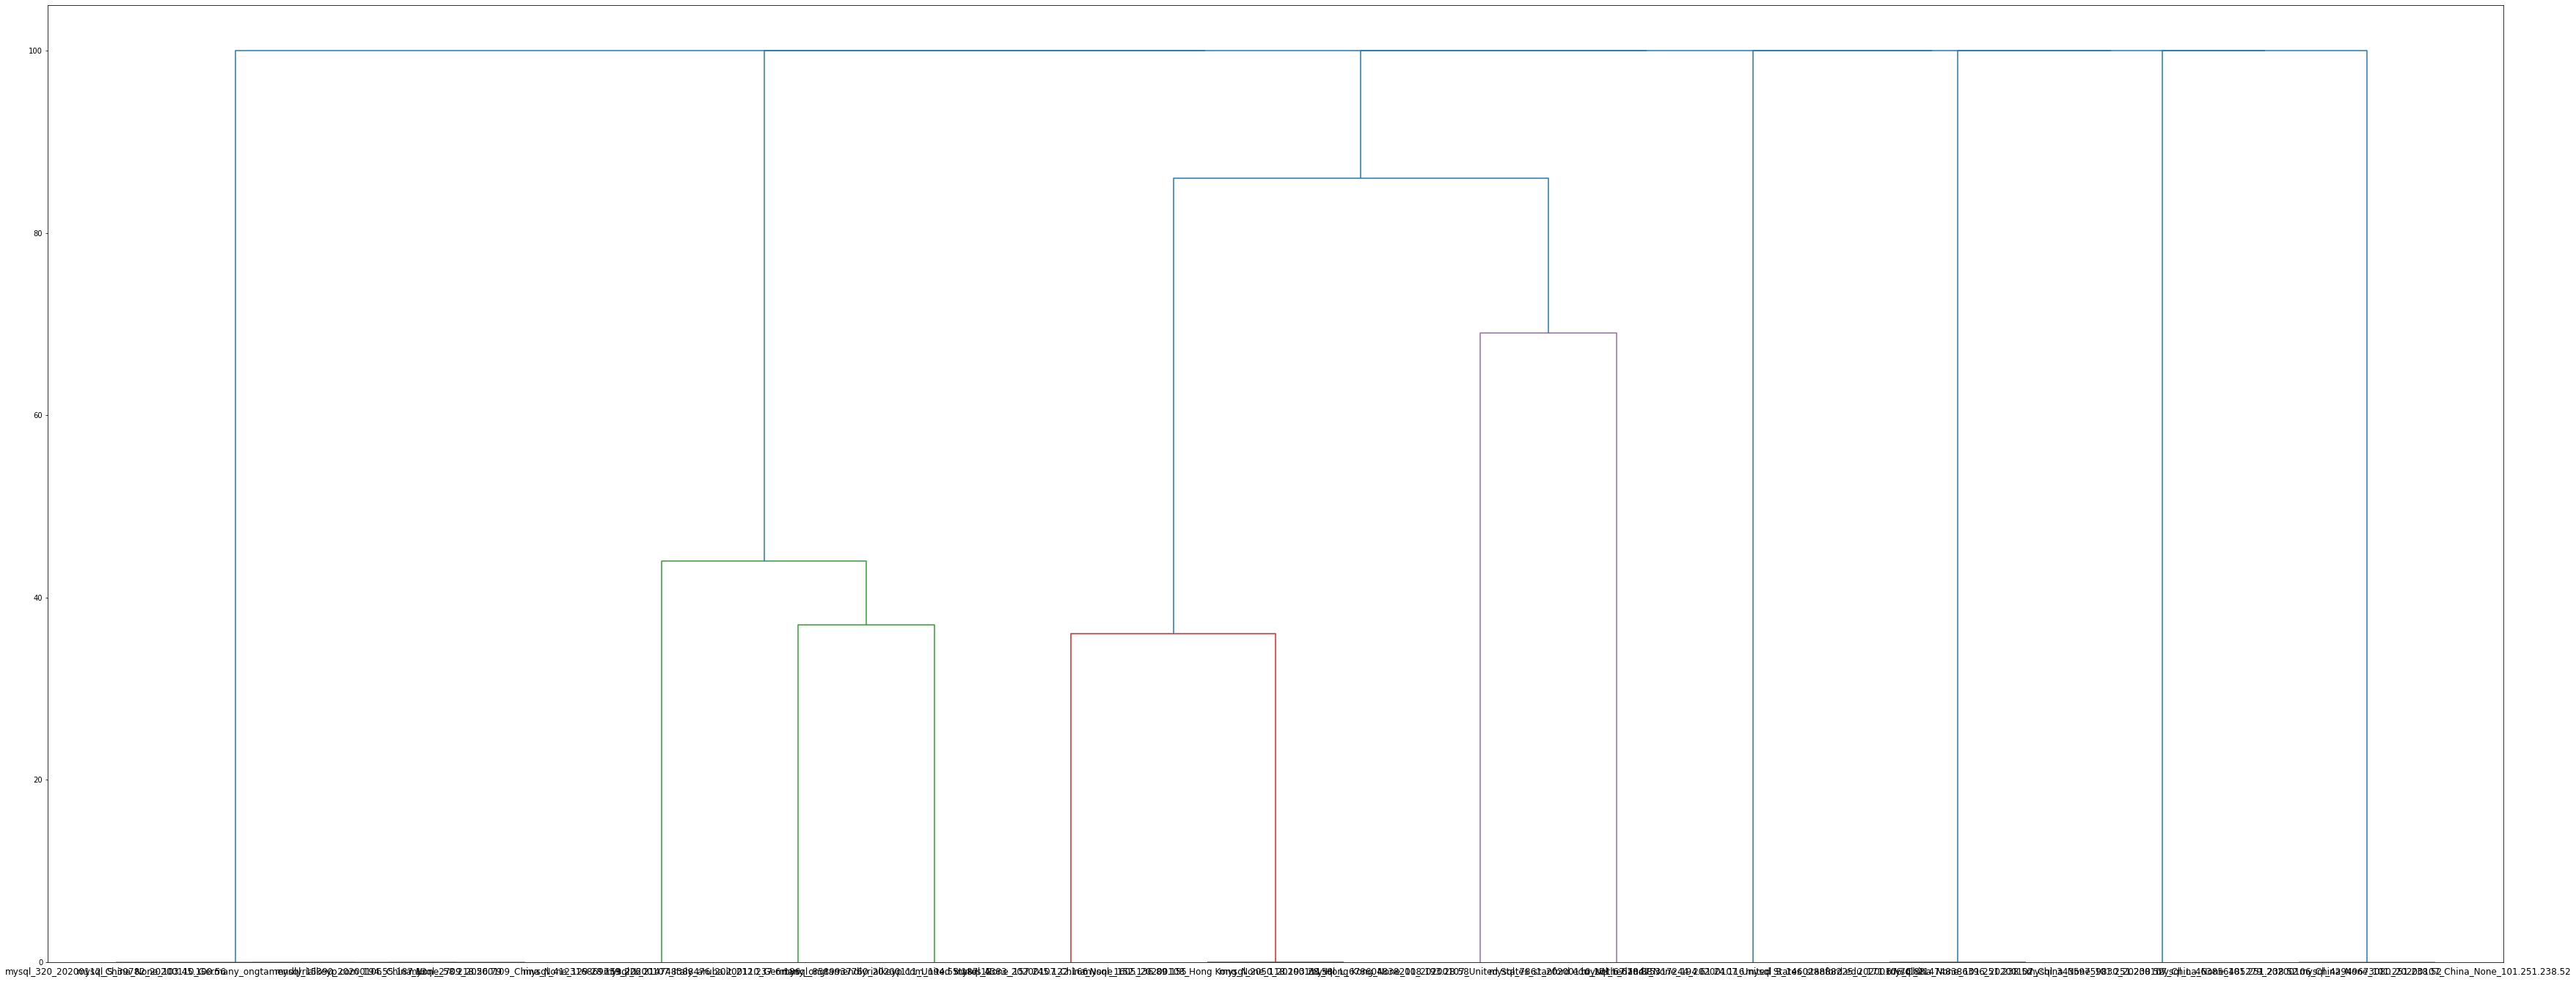

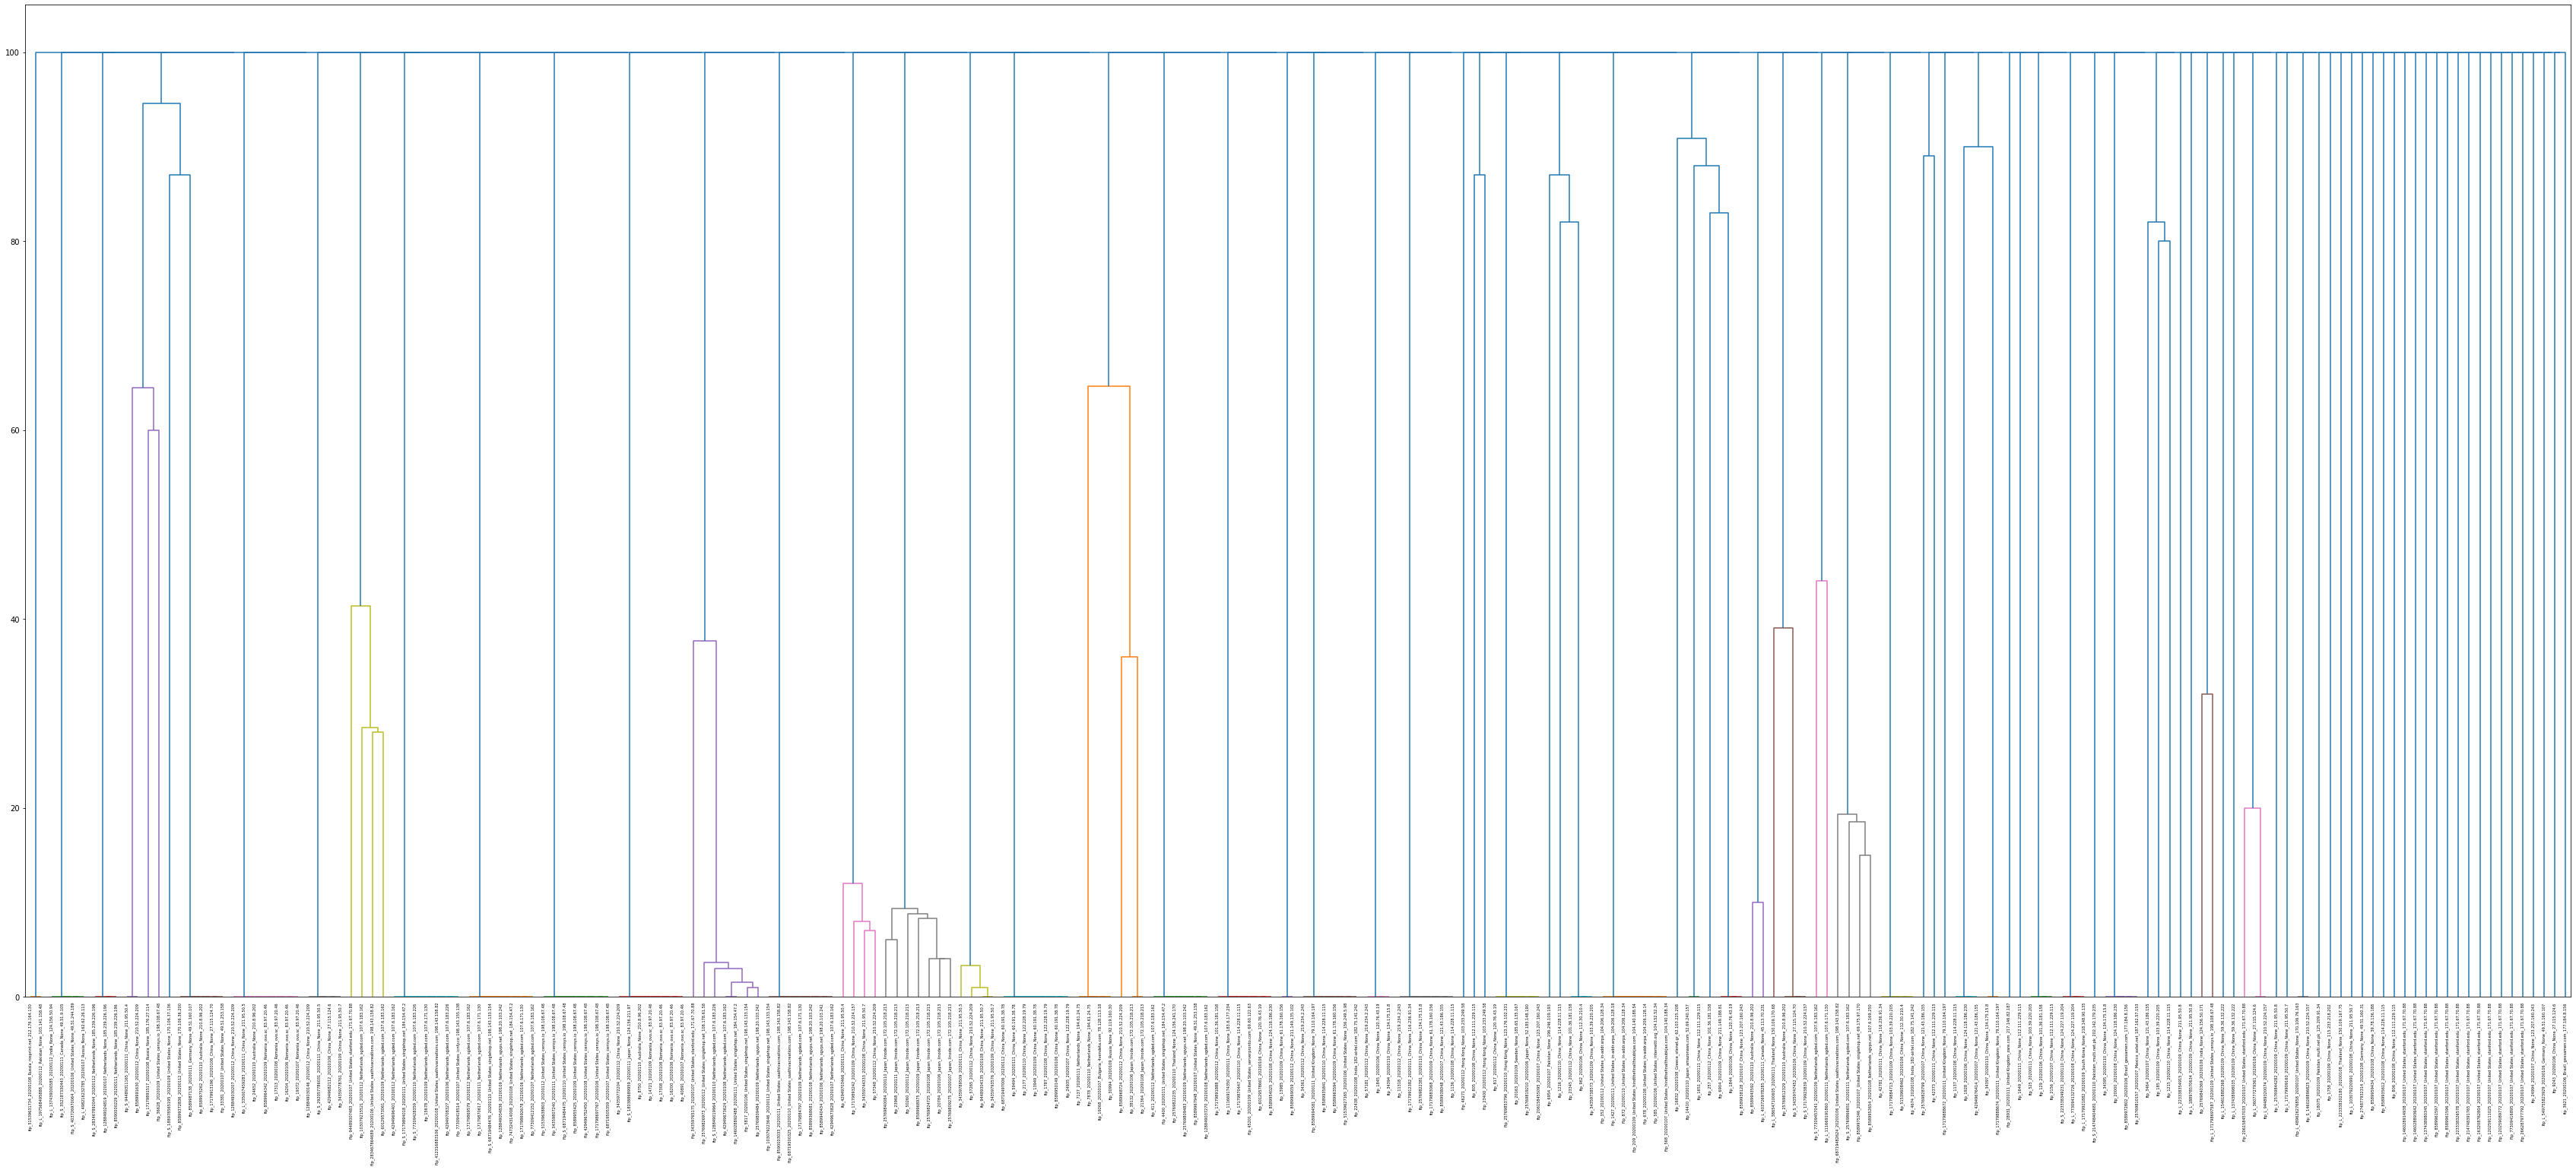

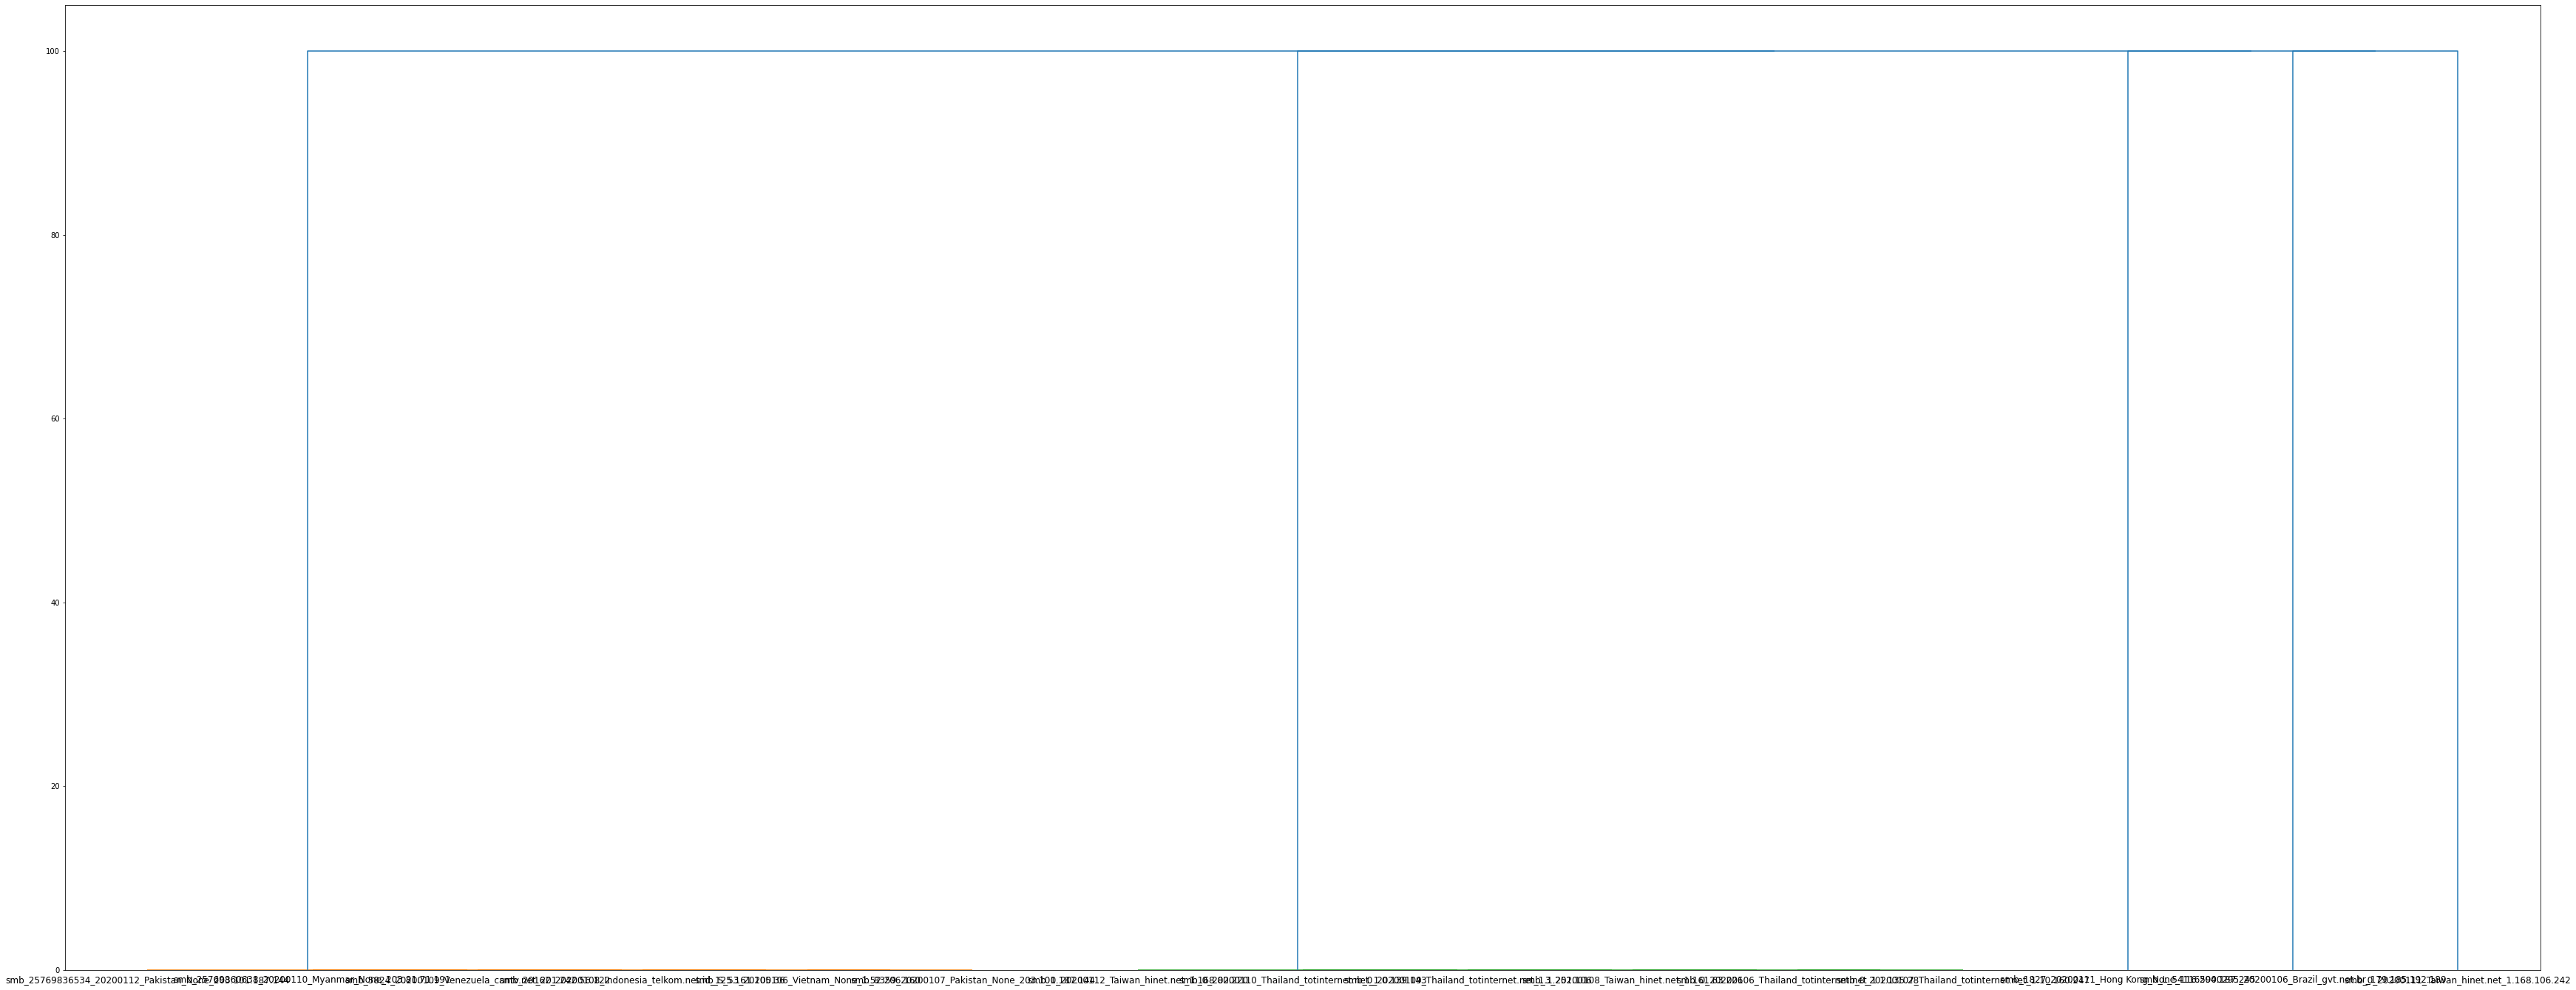

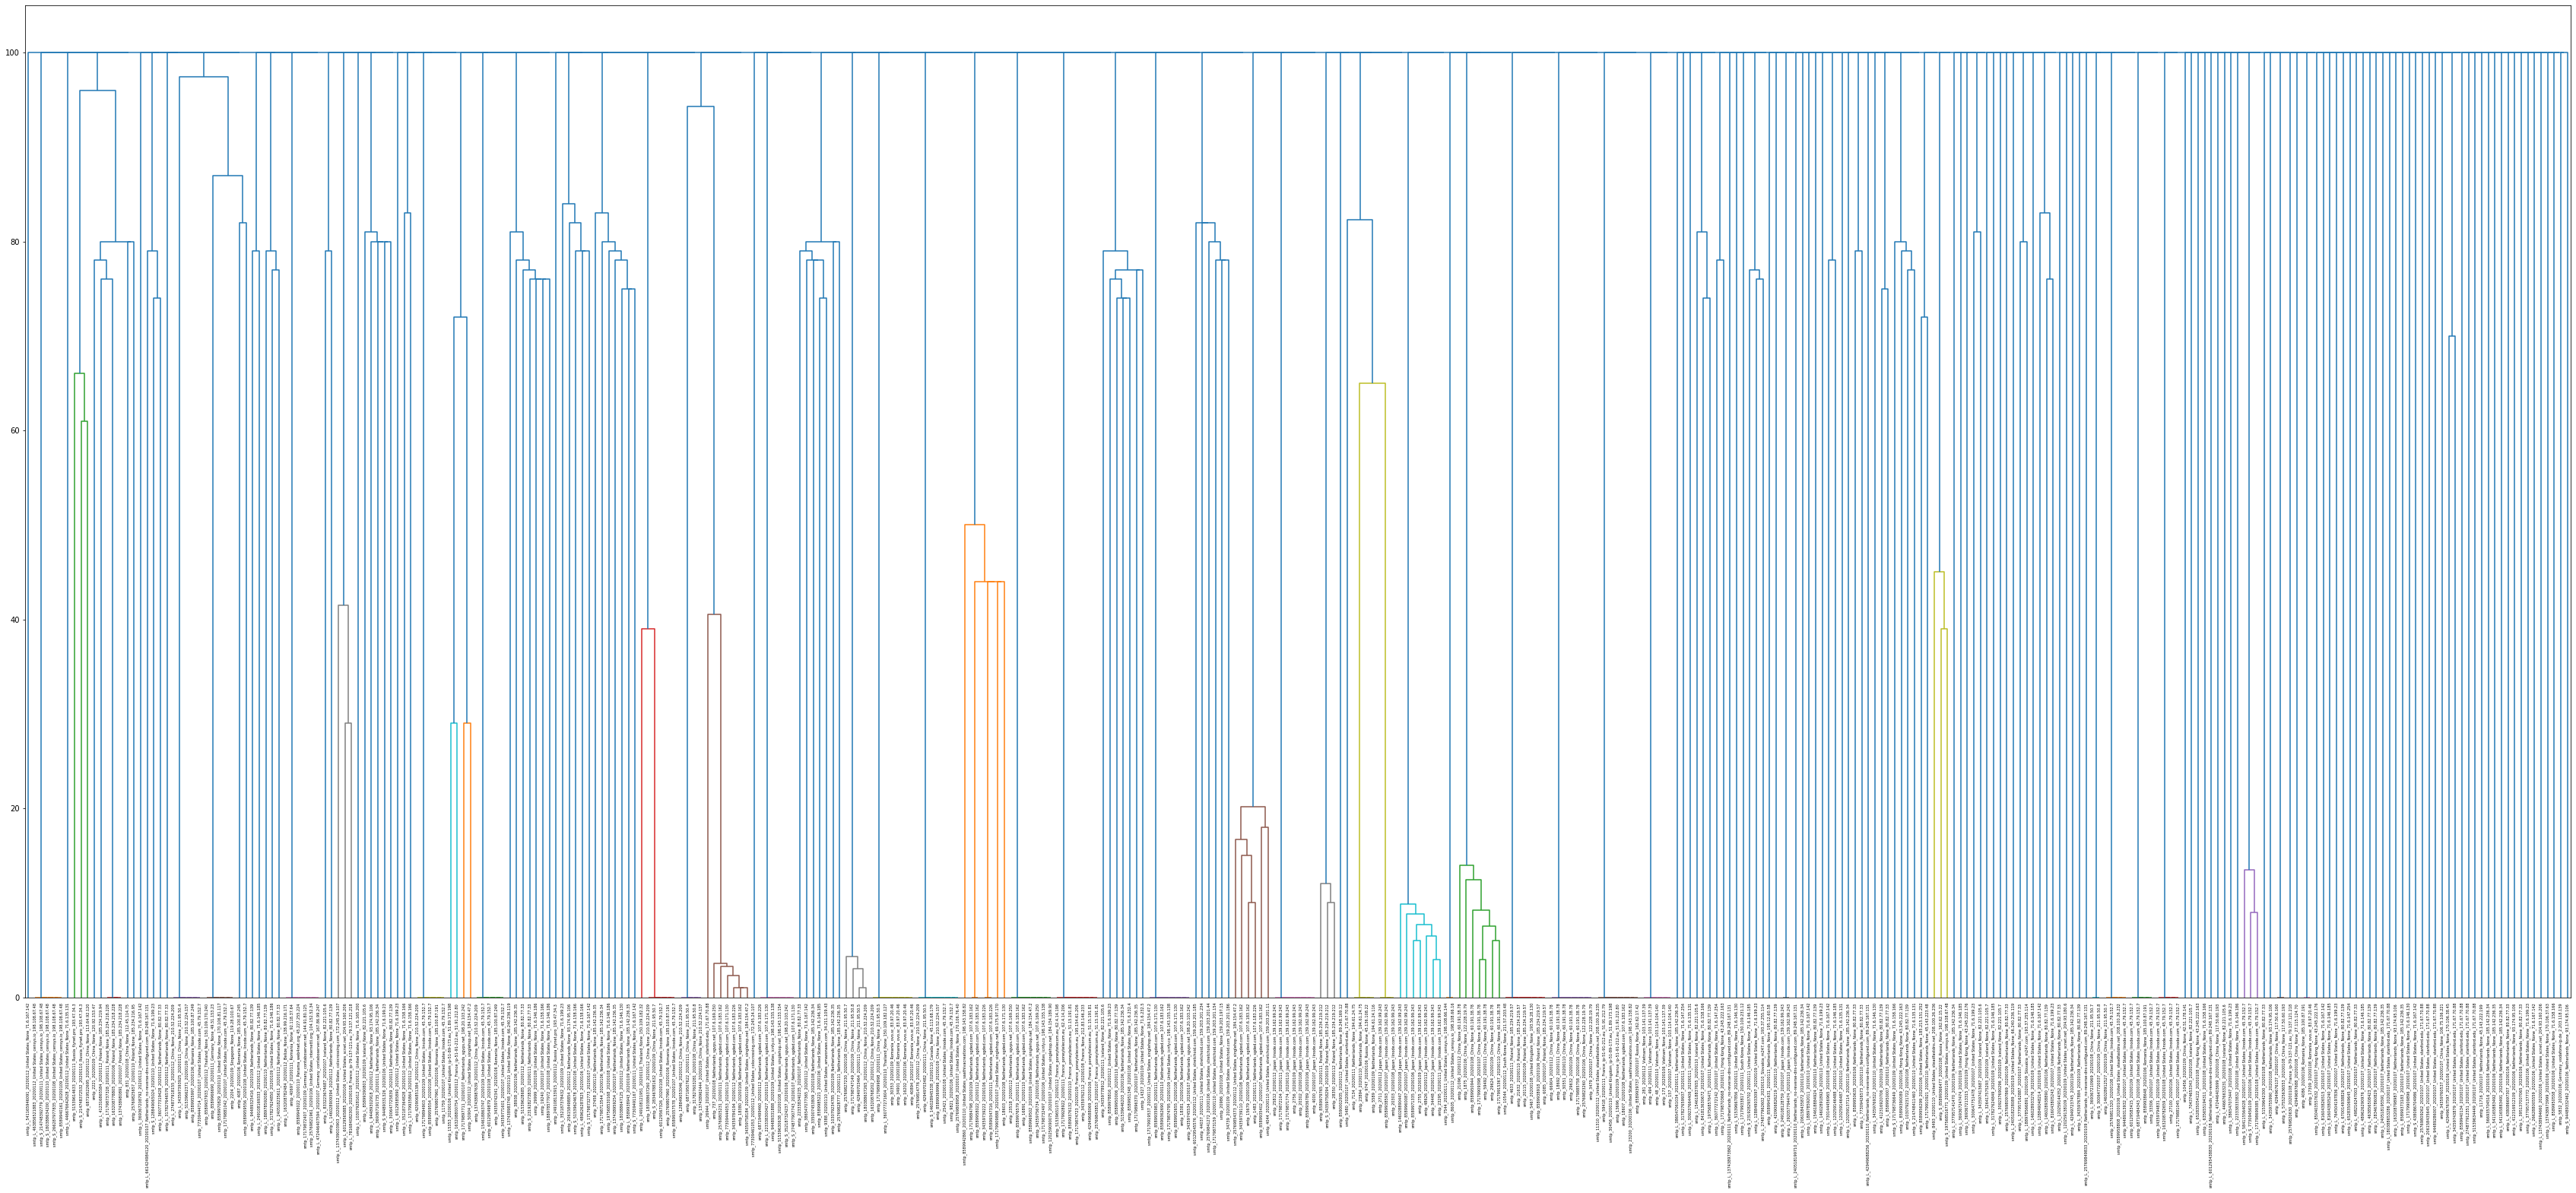

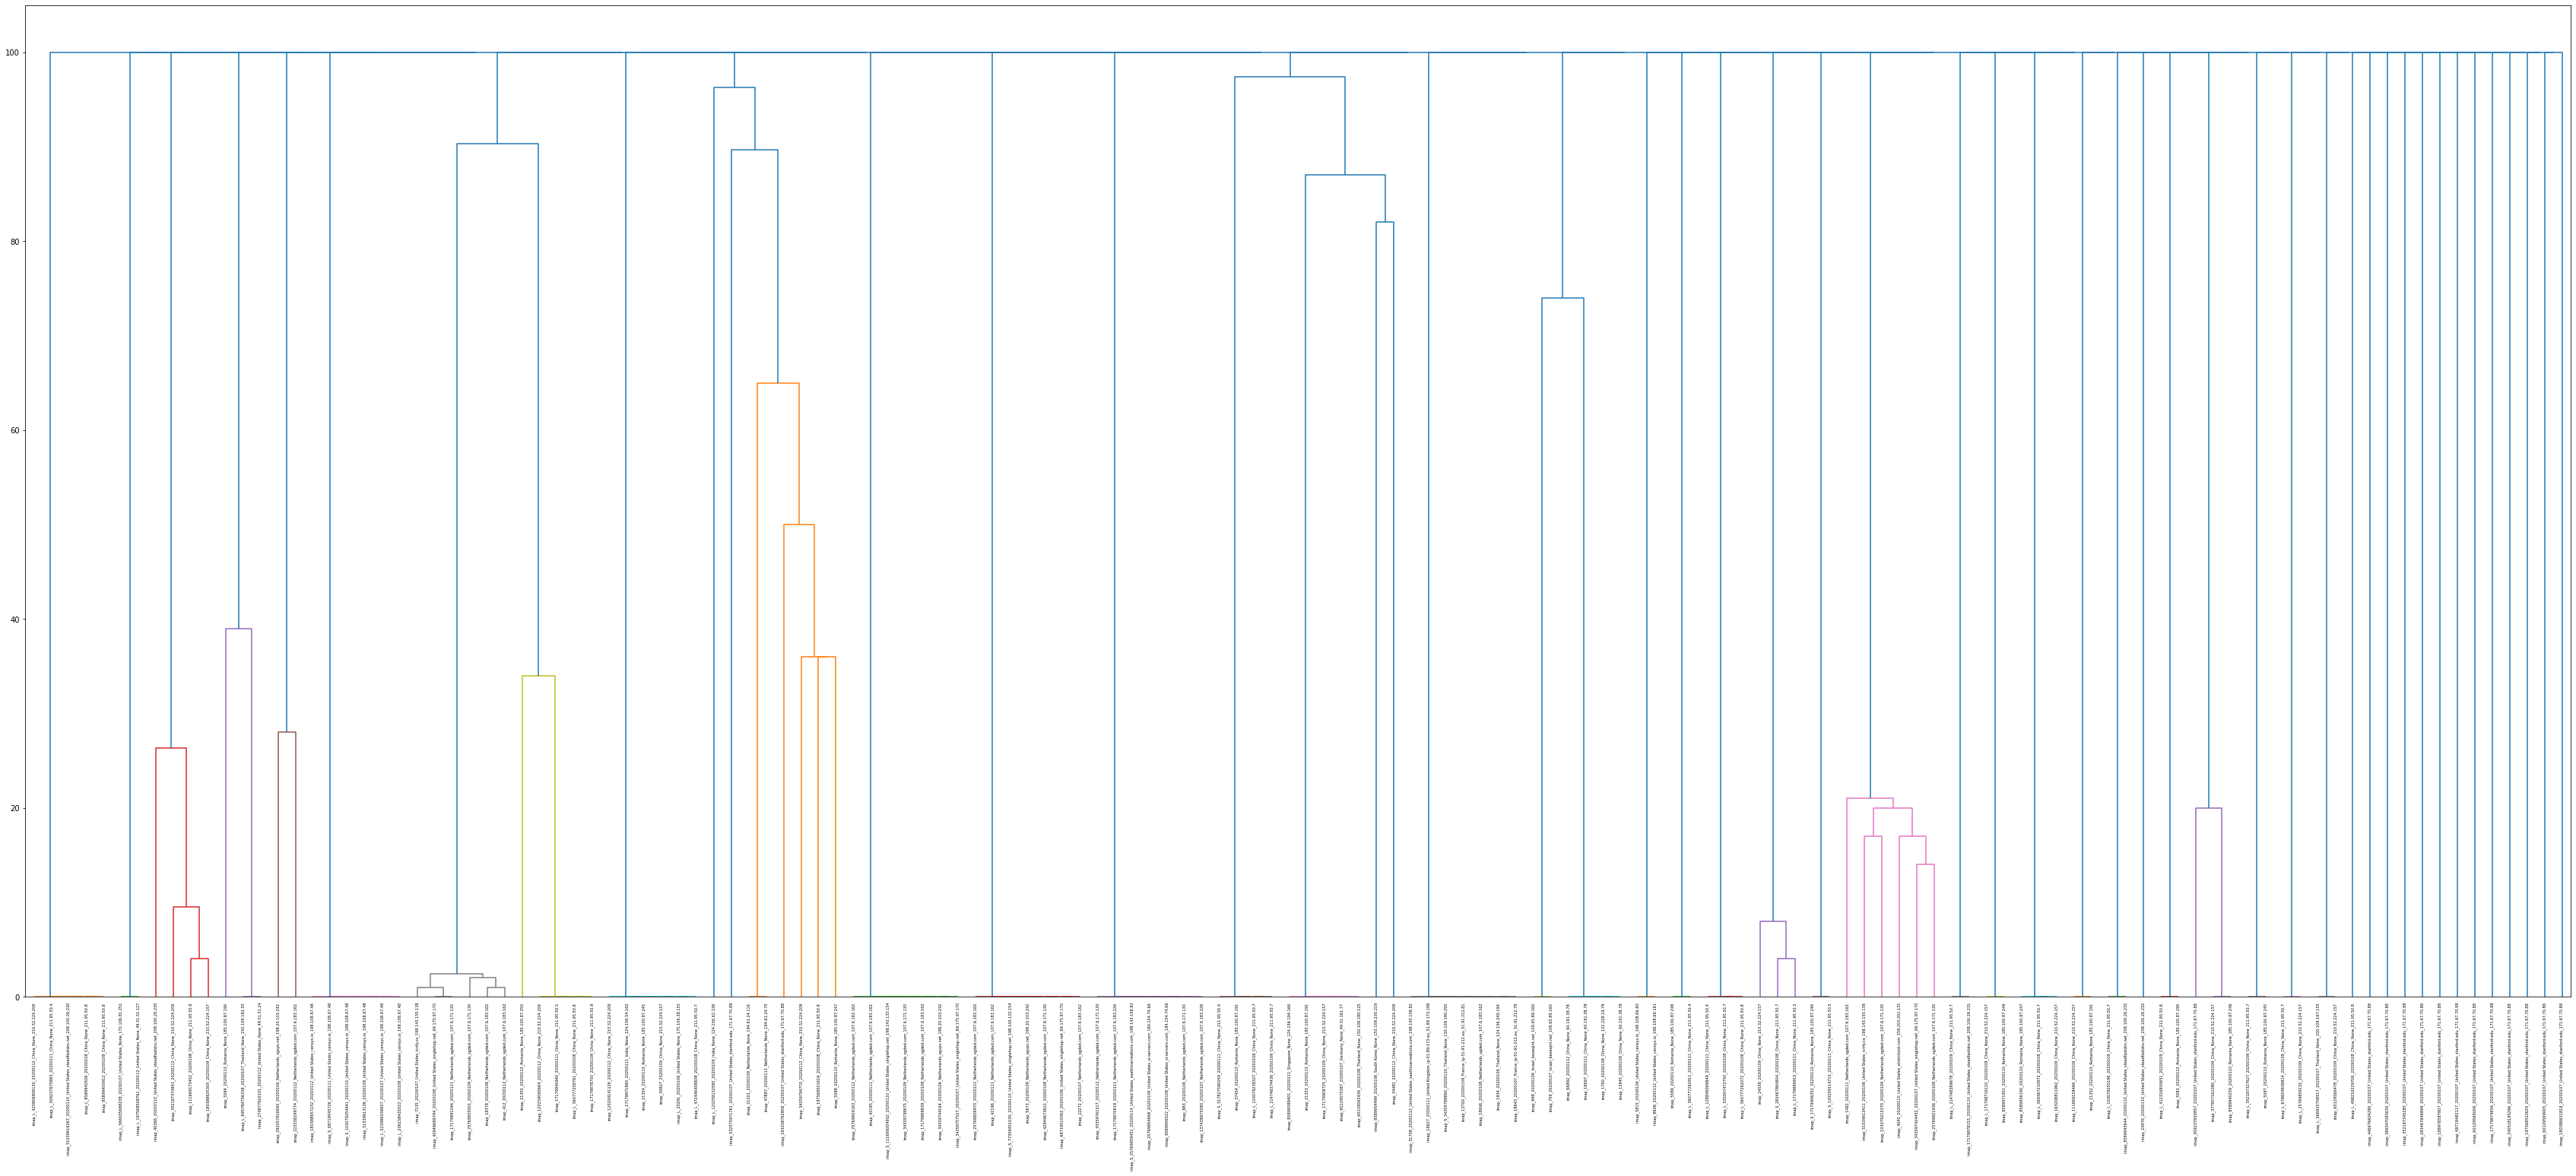

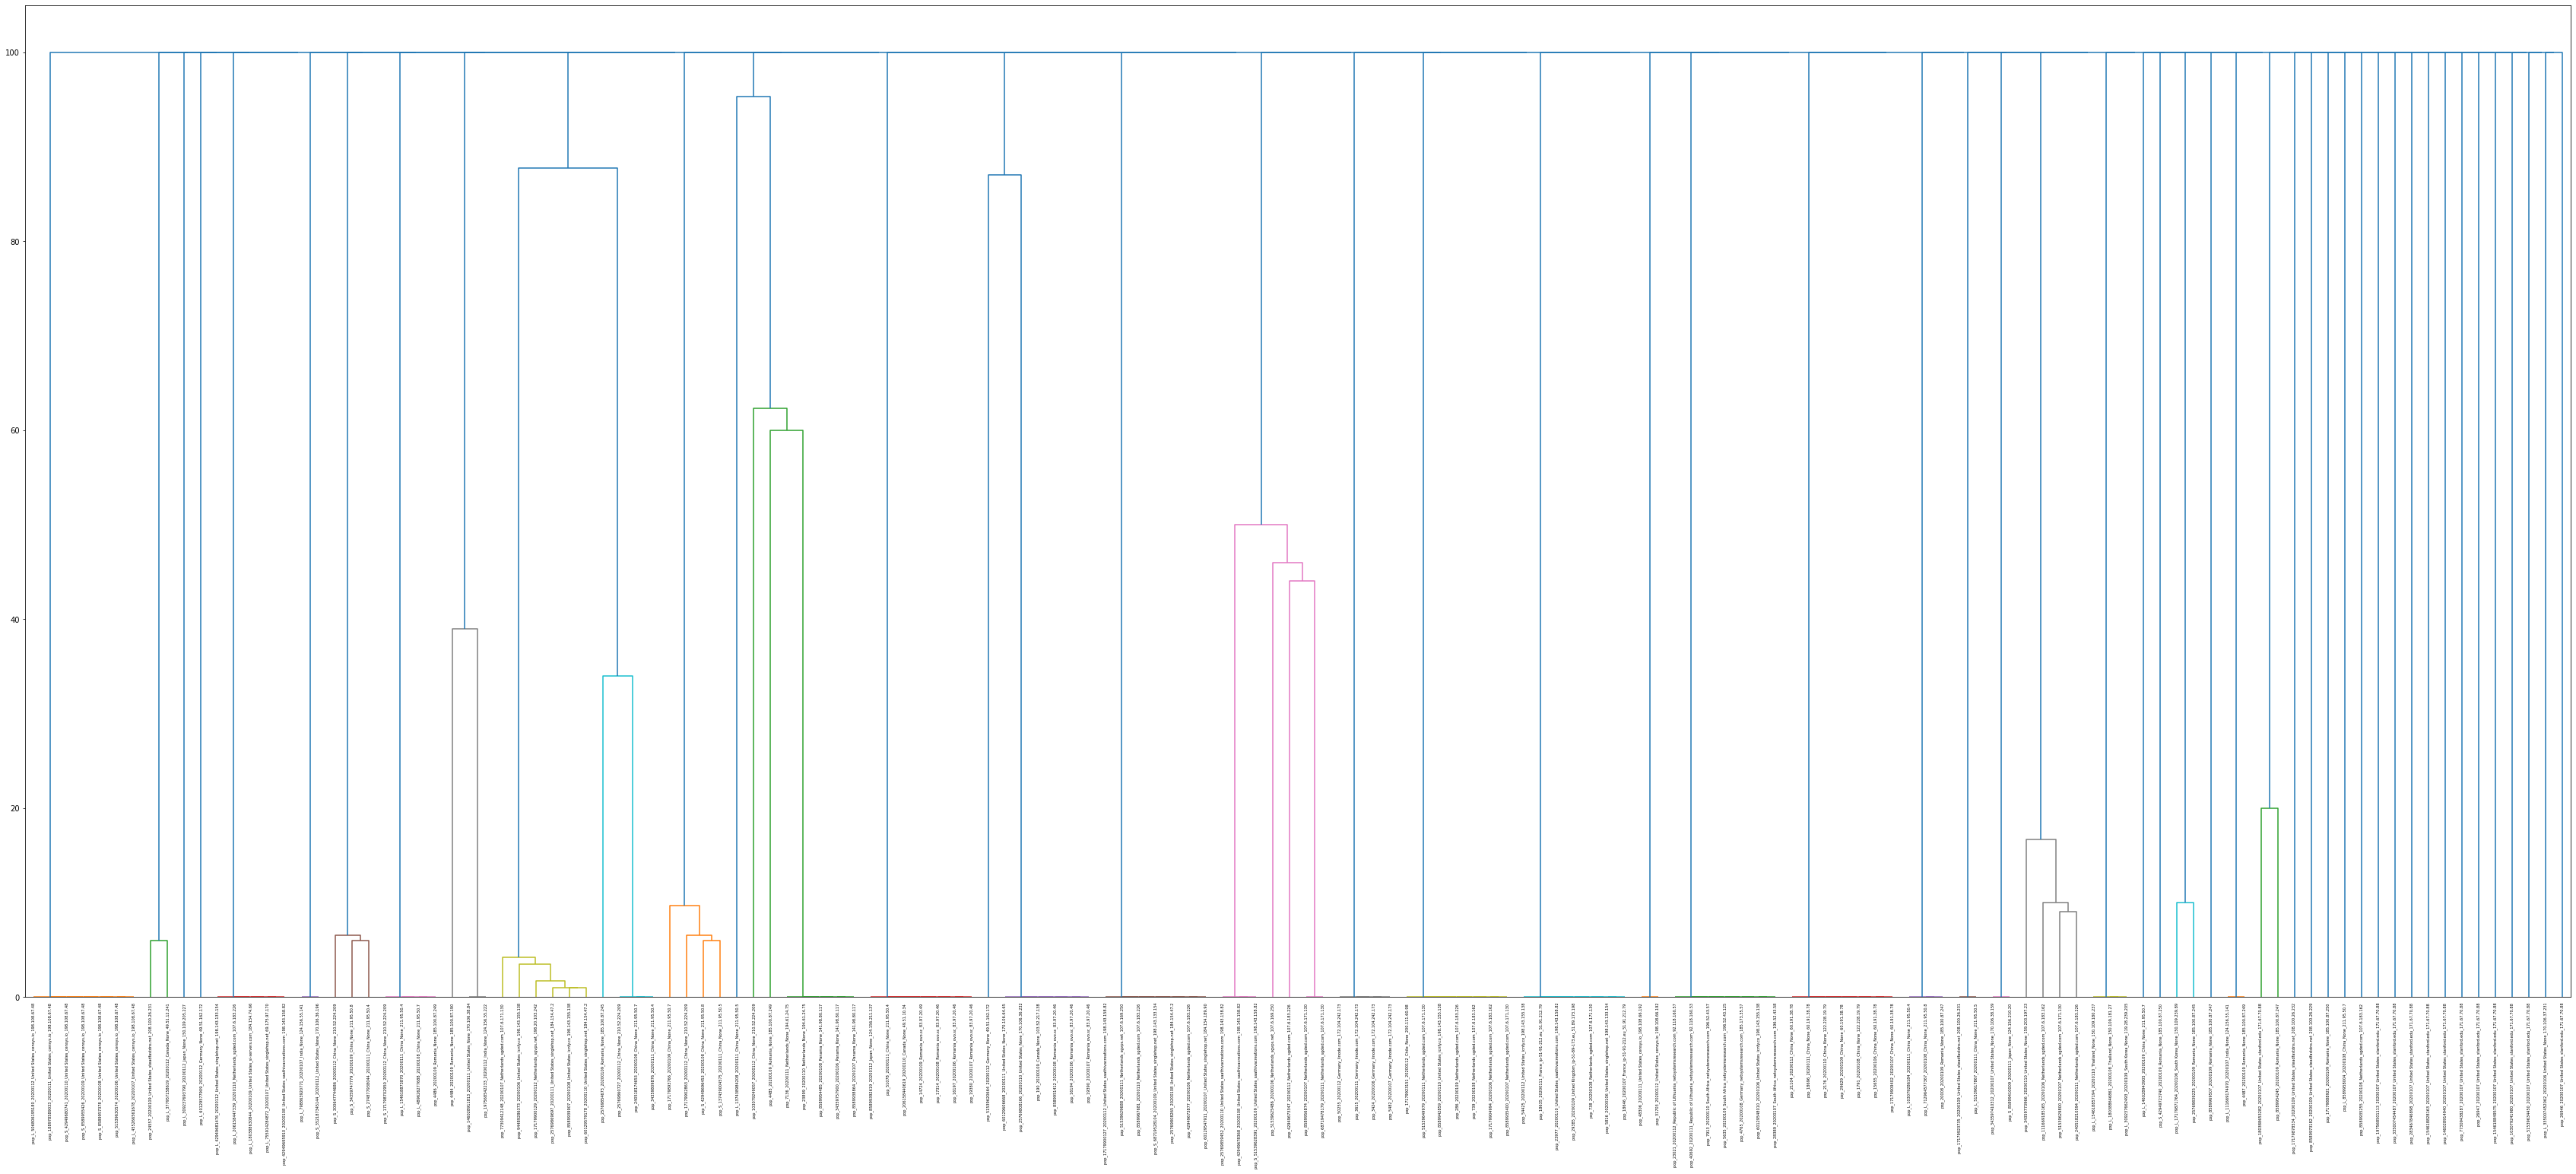

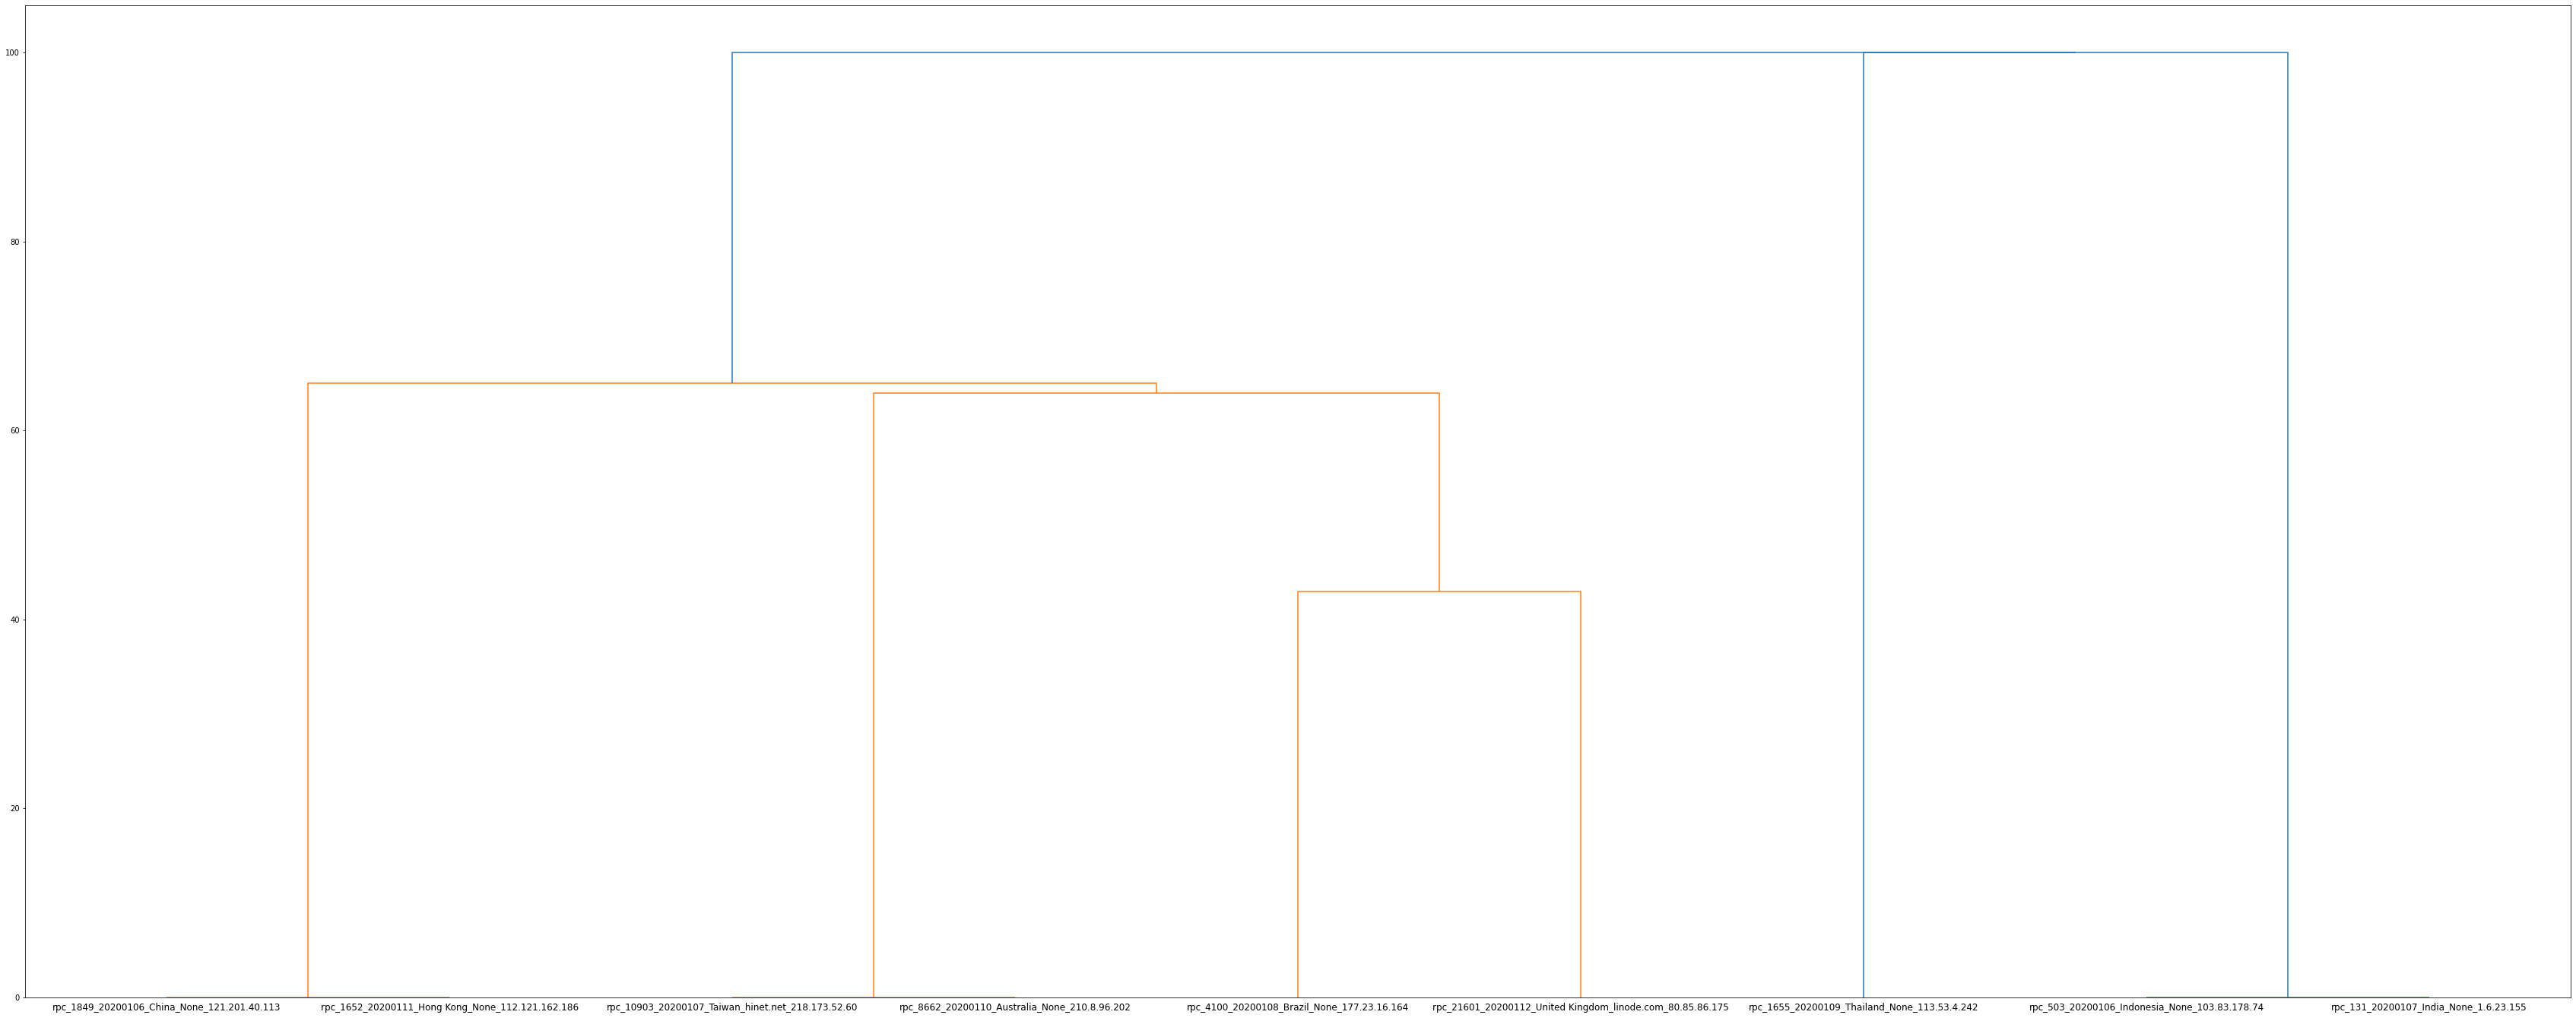

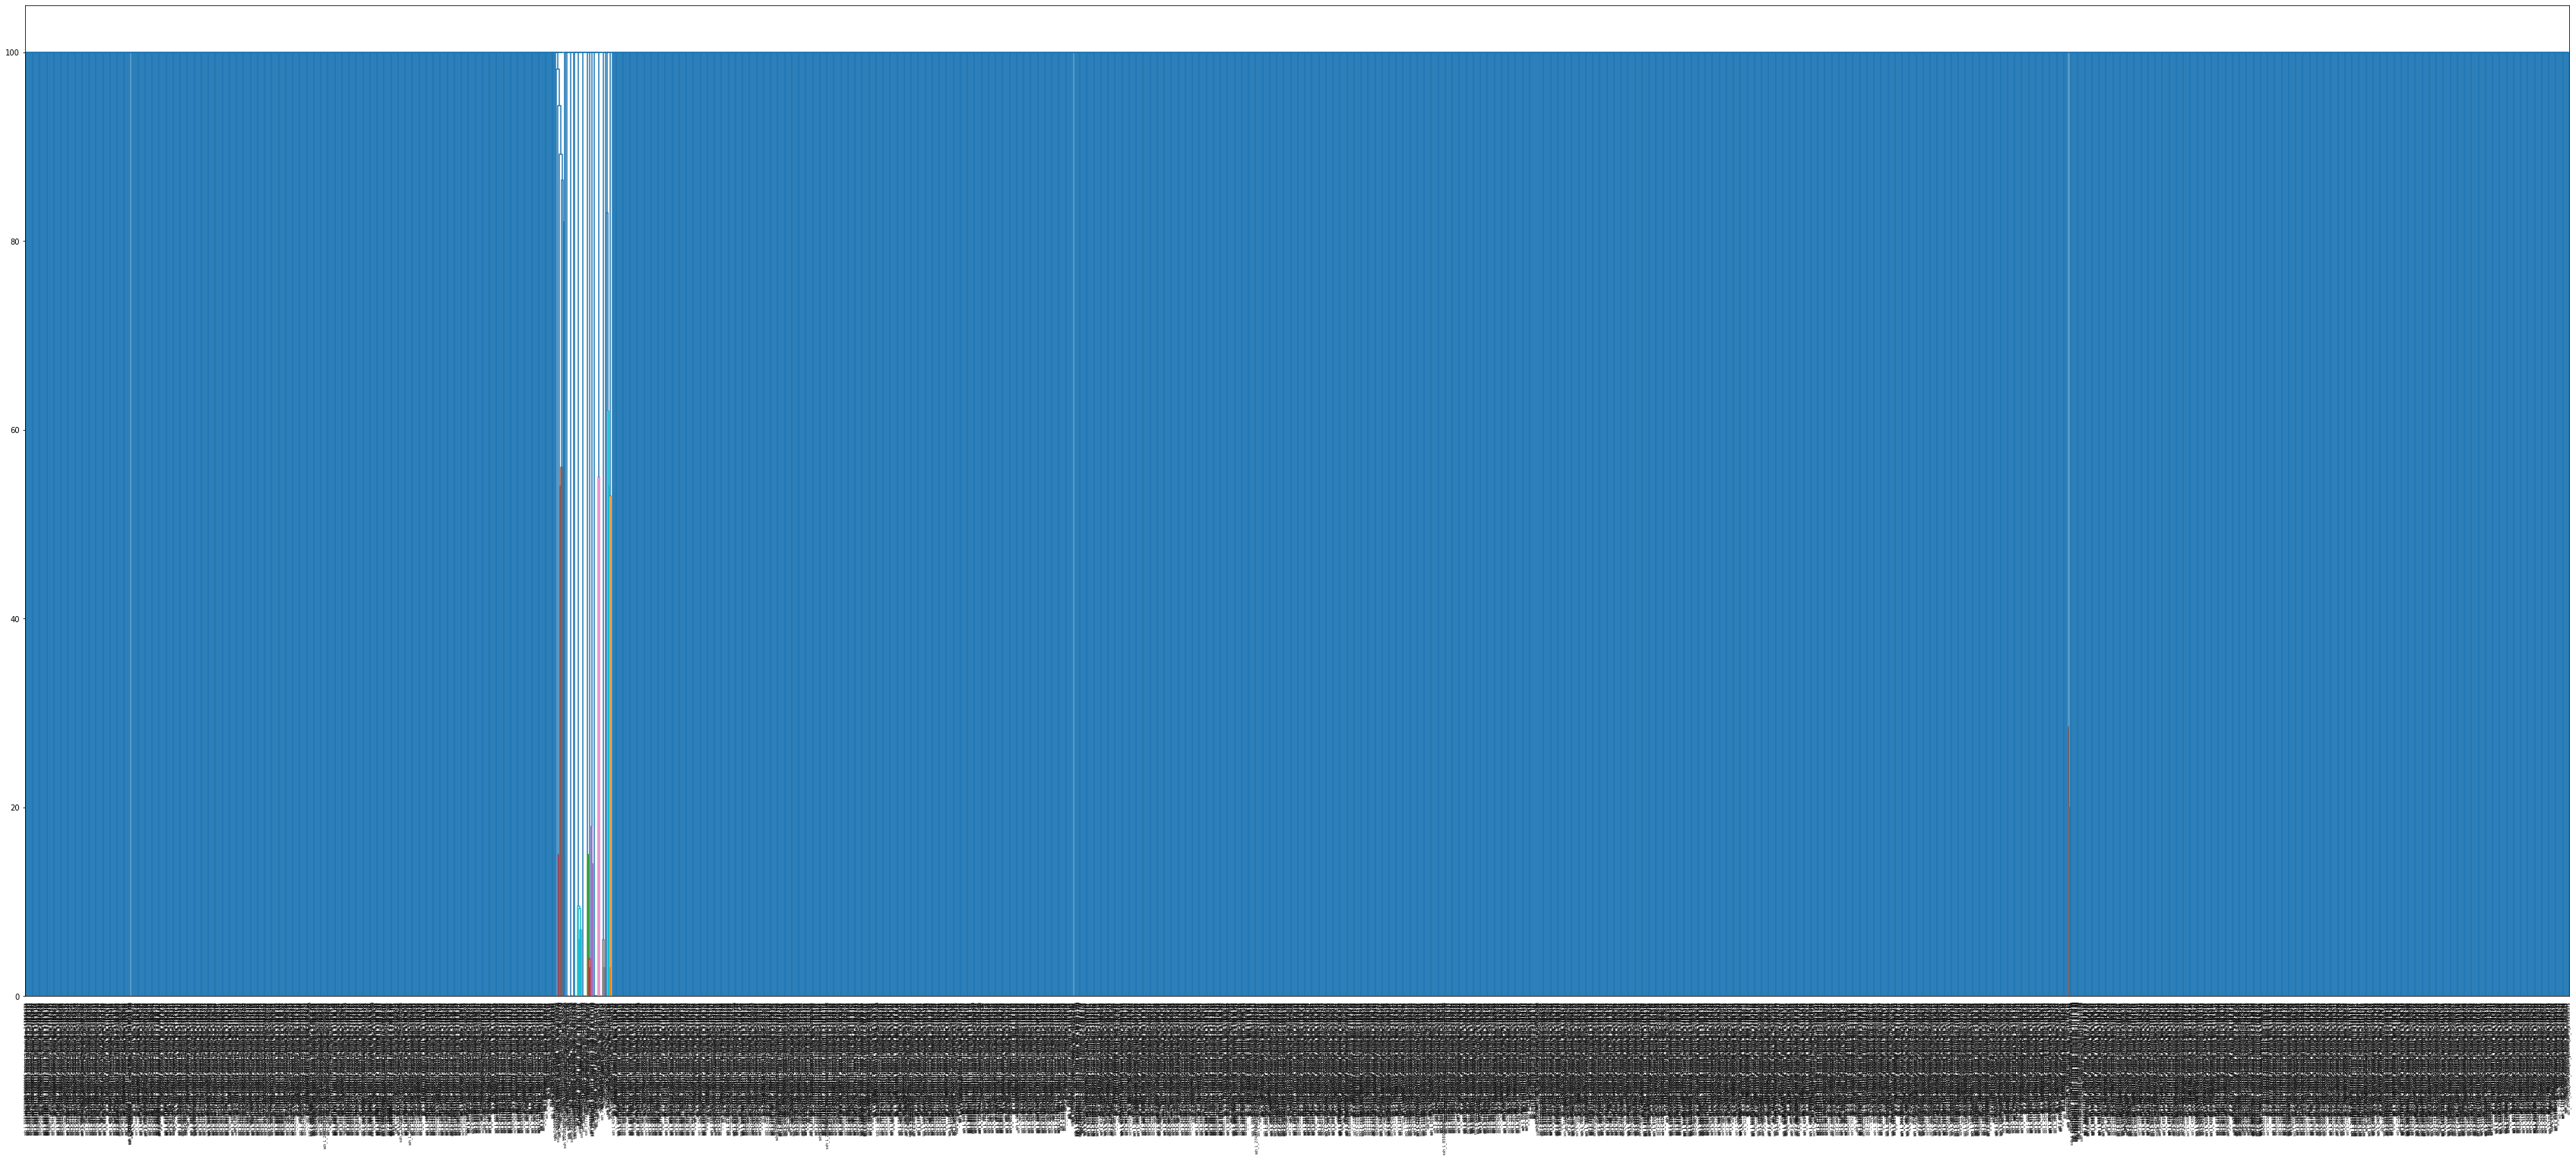

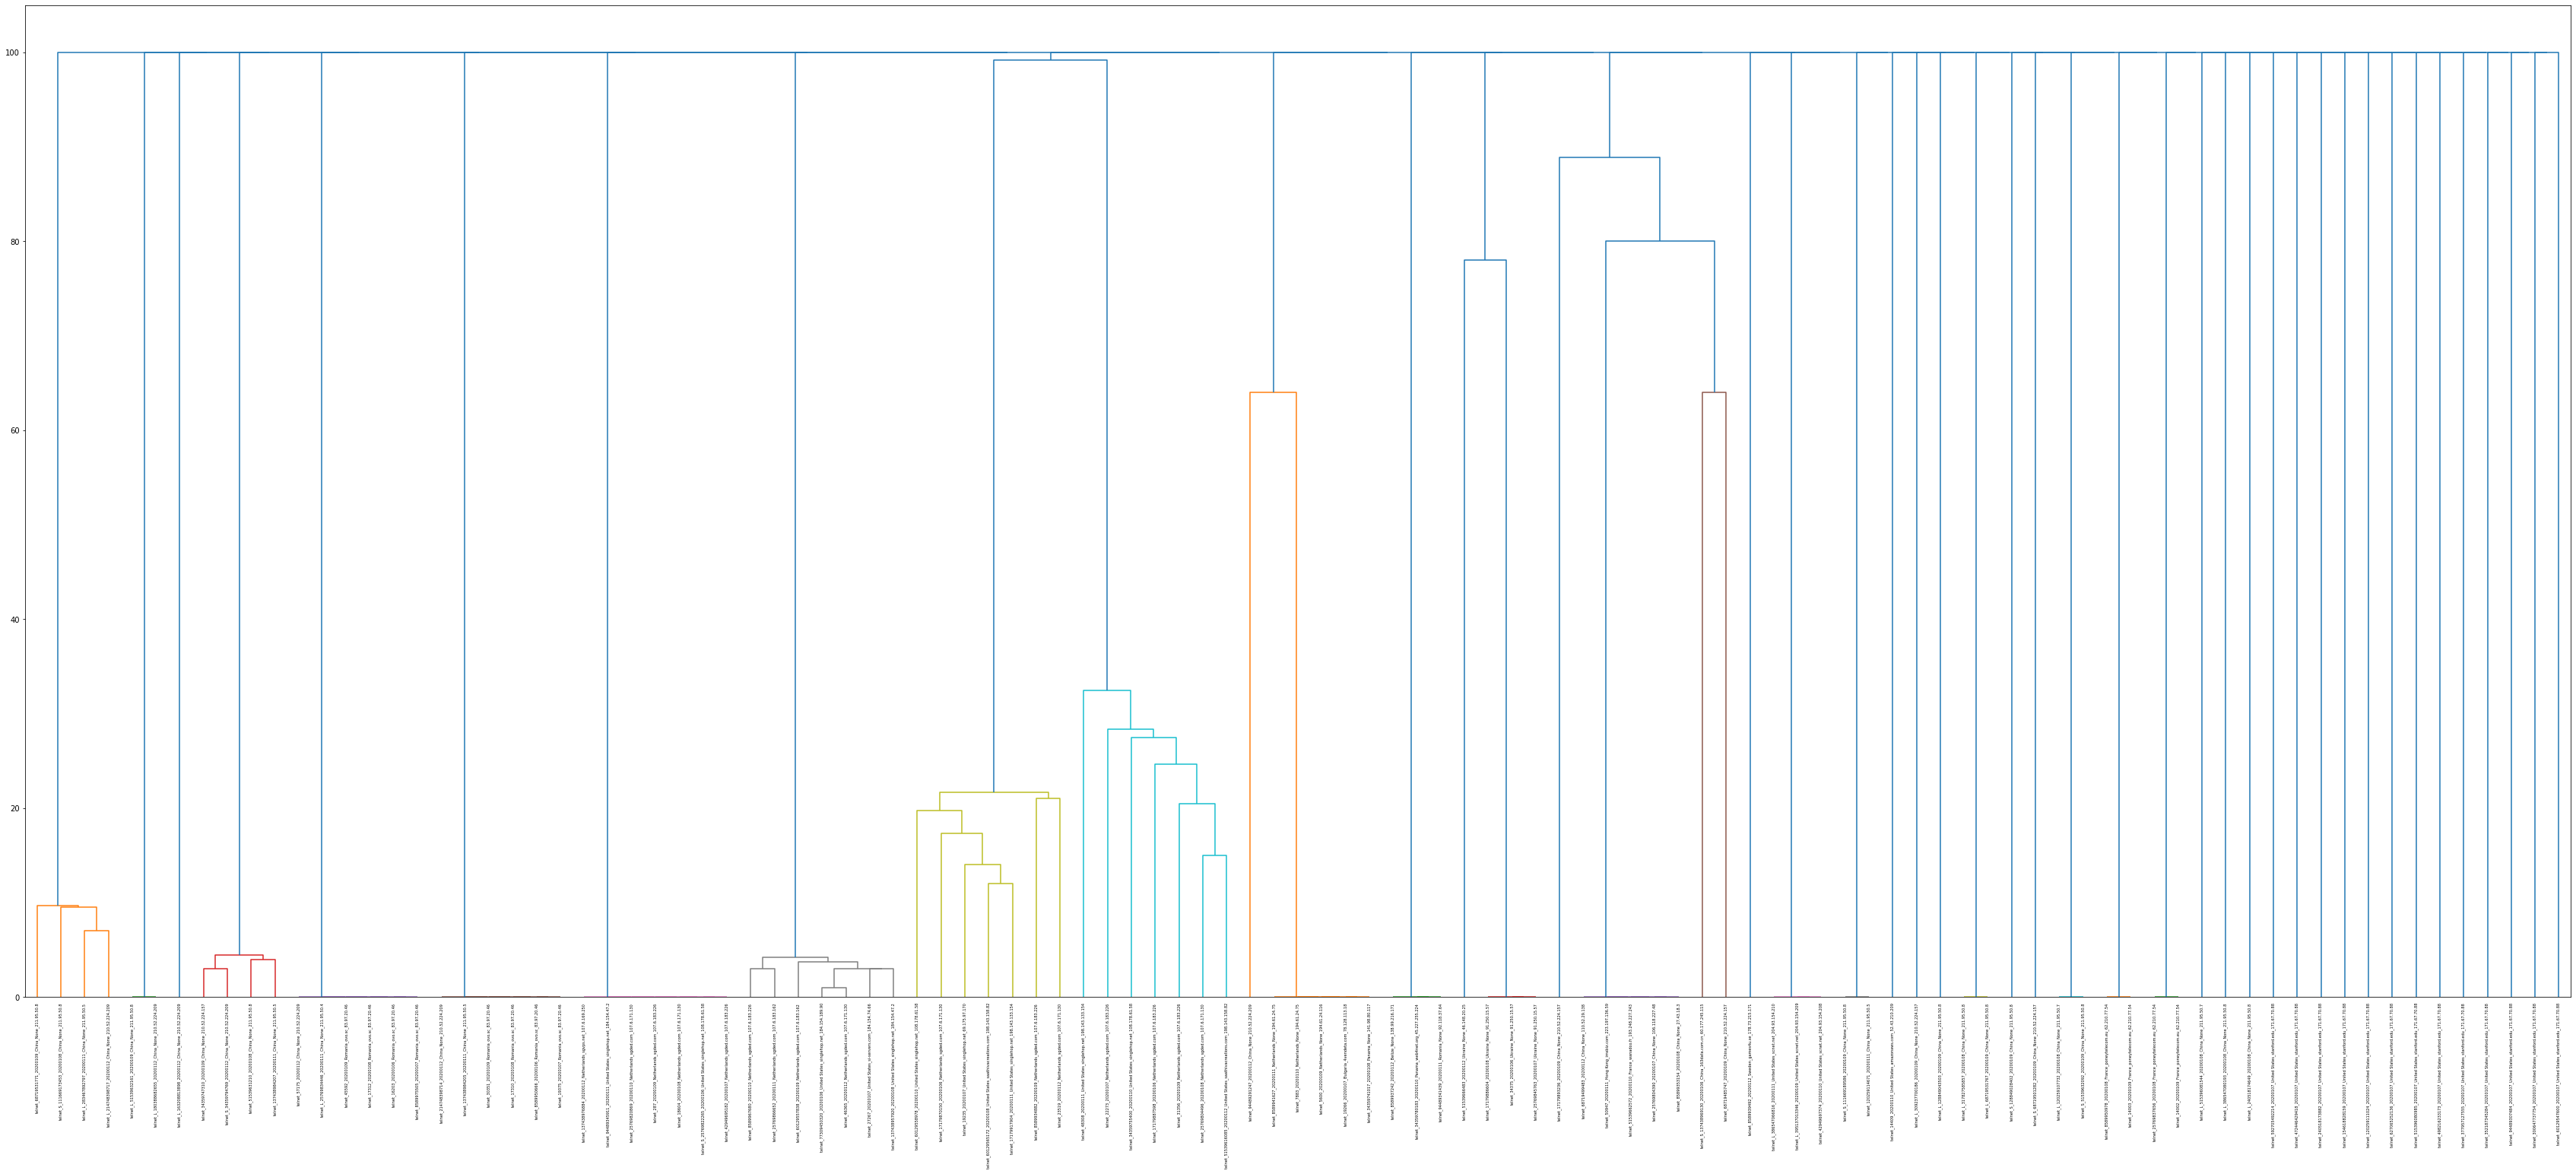

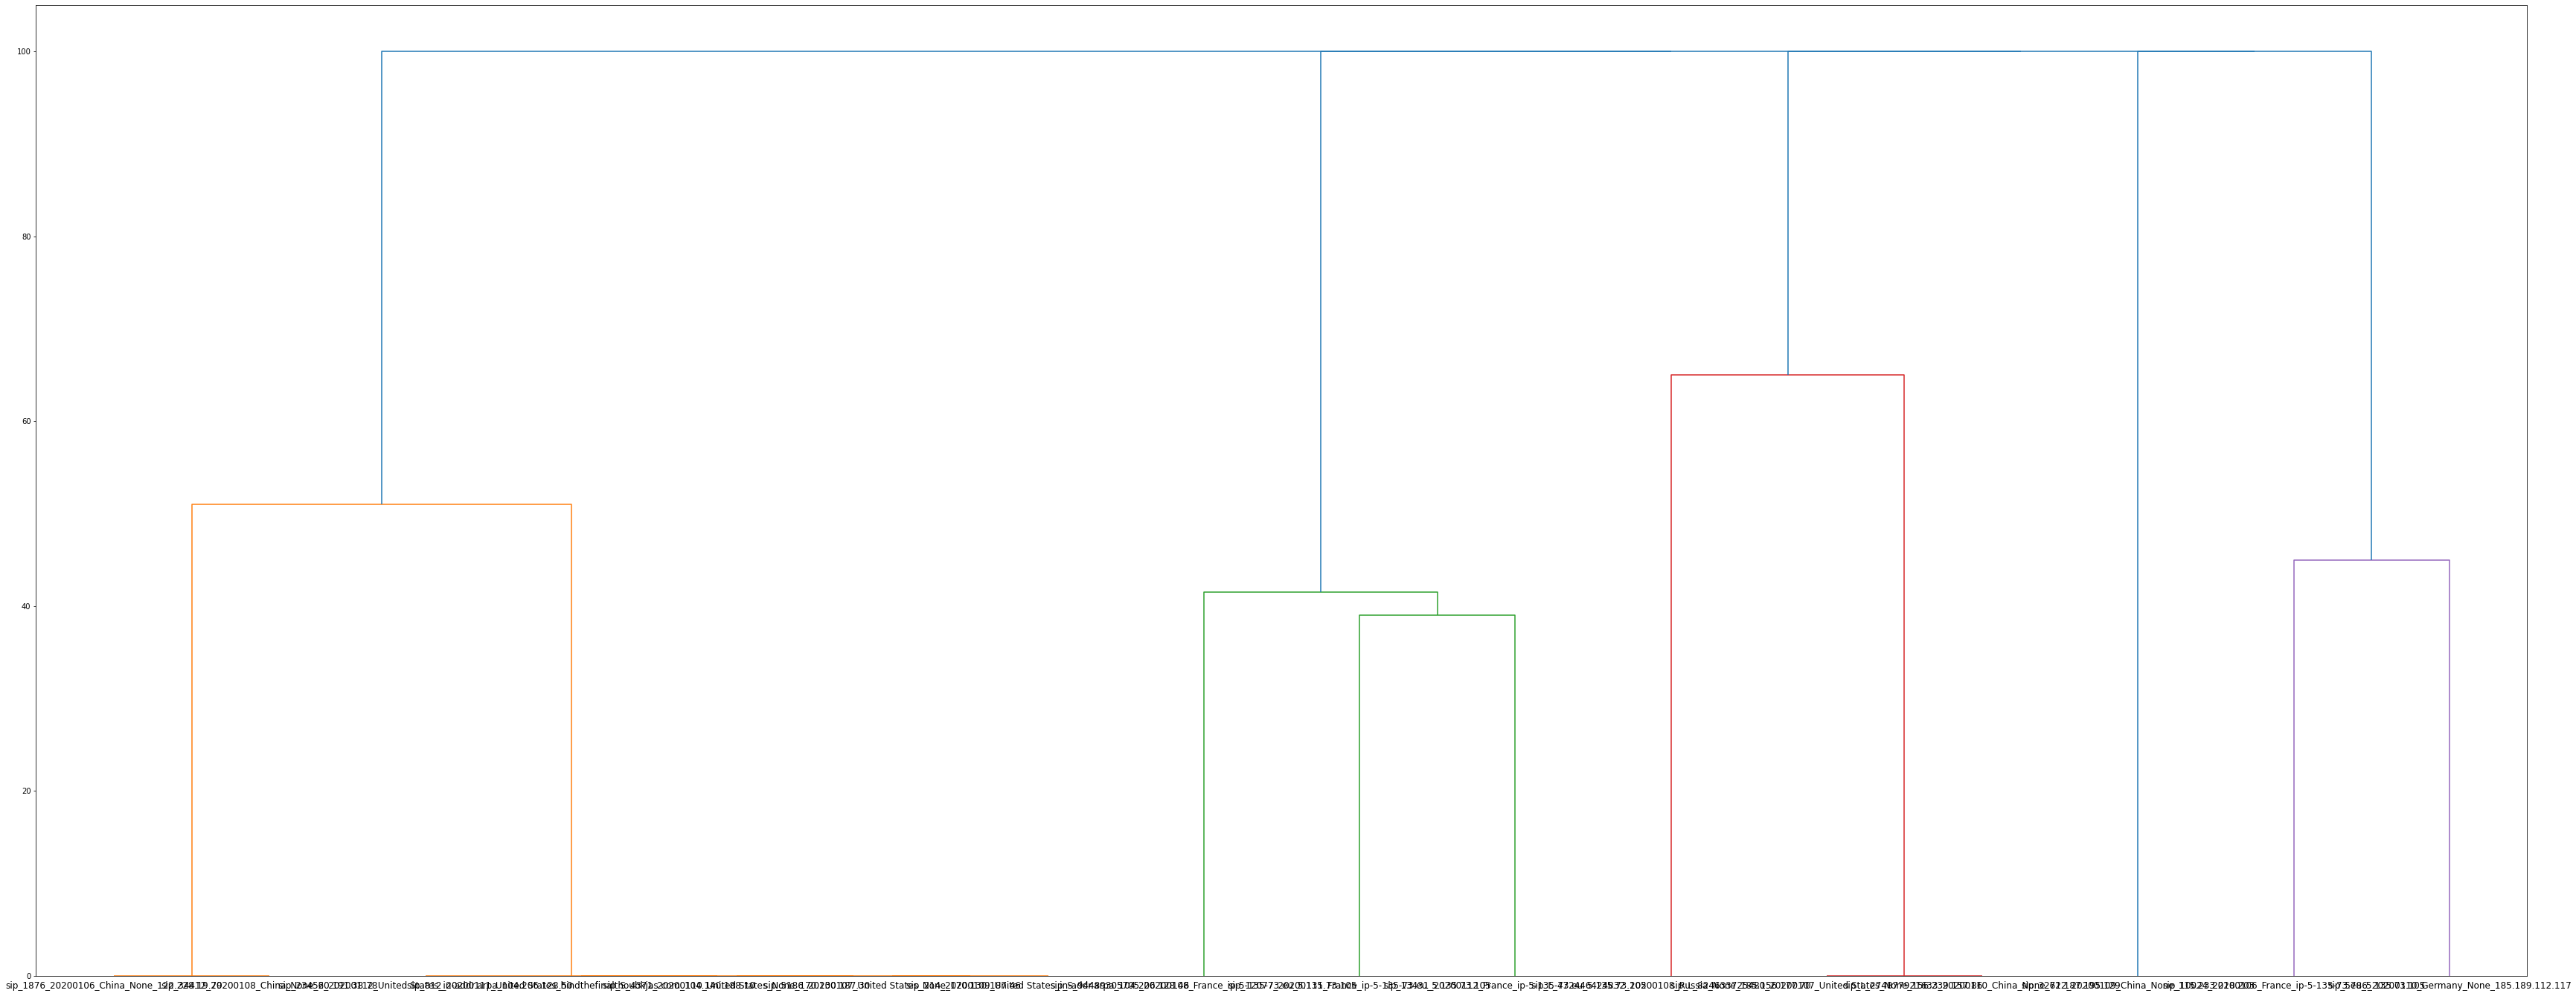

In [14]:
# 大家的pickle_dir都不同0109 0110 0111
# not save?

# time_li = ['02','10','30']
protocols_need = ['http','mysql','ftp','smb','smtp','imap','pop','rpc','ssh','telnet','sip']
# proto = HTTP, FTP, IMAP, MySQL, POP, RPC, SIP, SMB, SMTP, SSH, Telnet
for proto in protocols_need:
    three_dict = {}
    for time in time_li:
        path = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(time[:4])+'_'+str(time[4:6])+'_'+str(time[6:])+'/'+isp+'/case_pickles/'+proto+'_upgma_dict_'+str(time)+'.pkl'
        temp = pickle.load(open(path,'rb'))
        three_dict.update(temp)


    loner_dict = {}
    for k,v in three_dict.items():
        if '_L_' in k:
            loner_dict[k]=v
        if '_S_' in k:
            loner_dict[k] =v
    time_li2 = [int(x) for x in time_li]
    min_time  = str(min(time_li2))
    max_time = str(max(time_li2))
    filename = "_".join(time_li)
    pickle.dump(obj=(three_dict,loner_dict),file=open('/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_time[:4])+'_'+str(min_time[4:6])+'_'+str(min_time[6:])+'/'+isp+'/case_pickles/combine_dict_loner_dict_'+filename+'.pkl','wb'))
    three_upgma_df = pair_wise_score(three_dict) #改!!
    dn,Z = draw_upgma(three_upgma_df,
               picture_dir='/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_time[:4])+'_'+str(min_time[4:6])+'_'+str(min_time[6:])+'/'+isp+'/case_pictures/' #改!!
               ,name=str(min_time)+'-'+str(max_time)+'_upgma') #改!! 0106-0112_upgma            
loner_dict

## 畫跨天protocol大小圖

In [15]:
trend_dict_time_all = {}
trend_dict_country_all = {}
trend_dict_ip_all = {}
trend_dict_ssdeep_all = {}
def draw_trend_pic(date,proto,pickle_dir,trend_dict_time_all=trend_dict_time_all,trend_dict_country_all=trend_dict_country_all,trend_dict_ip_all=trend_dict_ip_all,trend_dict_ssdeep_all=trend_dict_ssdeep_all):
    '''
    GOAL: output dict to draw trend-circle picture
    
    Return: 4 dict for the same proto for the next day
    '''
    try:
        (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
         proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
    except ValueError:
        try:
            (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
             proto_upgma_dict,stat_df,df2) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
        except ValueError:
            try:
                (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                        proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
            except ValueError:
                (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                        proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
    except FileNotFoundError:
        print("!!File Not Found:",date,proto,"!!")
        return trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all


    def ssdeep_compare(target_hash,candidate_df):
        '''
        Input1: string of hash
        Input2: dataframe of candidate
        '''
        def compare(candidate_hash):
            if type(candidate_hash) == str:
                return ssdeep.compare(target_hash,candidate_hash)
            else:
                score_li = []
                for c_h in candidate_hash:
                    score_li.append(ssdeep.compare(target_hash,c_h))
                return max(score_li)
        return candidate_df.hash.map(compare)

    trend_dict_time = {}
    trend_dict_country = {}
    trend_dict_ip = {}
    trend_dict_ssdeep = {}
    candidate_df = pd.DataFrame(trend_dict_ssdeep_all.items(),columns=['idx','hash']) #其他已經有的cluster
    for key,value in proto_big_dict.items():
        target = proto_df_payload[proto_df_payload.idx == key]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q2 = int(t_len*0.5)
        t_q2_key = target.iloc[q2,-1] #要跟別人比較的cluster hash
        if trend_dict_ssdeep_all == {}: #第一次
            member_li = value[:]
            
            t_q2_member1 = proto_df_payload[proto_df_payload.idx == member_li[-1]] # member list最後一個
            t_q2_member1 = t_q2_member1.reset_index(drop=True)
            t_len = len(t_q2_member1)
            q2 = int(t_len*0.5)
            t_q2_member1 = t_q2_member1.iloc[q2,-1]
            
            t_q2_member2 = proto_df_payload[proto_df_payload.idx == max(member_li)] #member list最大的那個
            t_q2_member2 = t_q2_member2.reset_index(drop=True)
            t_len = len(t_q2_member2)
            q2 = int(t_len*0.5)
            t_q2_member2 = t_q2_member2.iloc[q2,-1]
            
            trend_dict_ssdeep[str(date)+"_"+str(key)] = [t_q2_key,t_q2_member1,t_q2_member2] #可以增加hash candidate?
            member_li.append(key)
            select_df = proto_df.loc[member_li]
            time_li = select_df.session_time.tolist()
            trend_dict_time[str(date)+"_"+str(key)] = time_li
            country_li = select_df.country.tolist()
            ip_li = select_df.ip_src.tolist()
            assert len(time_li) == len(country_li) == len(ip_li)
            trend_dict_country[str(date)+"_"+str(key)] = country_li
            trend_dict_ip[str(date)+"_"+str(key)] = ip_li
        else: #後面幾次
            candidate_df['score'] = ssdeep_compare(t_q2_key,candidate_df) 
            max_score = candidate_df.score.max()
            if max_score < 1: #都沒有相近的
                
                member_li = value[:]
                
                t_q2_member1 = proto_df_payload[proto_df_payload.idx == member_li[-1]] # member list最後一個
                t_q2_member1 = t_q2_member1.reset_index(drop=True)
                t_len = len(t_q2_member1)
                q2 = int(t_len*0.5)
                t_q2_member1 = t_q2_member1.iloc[q2,-1]

                t_q2_member2 = proto_df_payload[proto_df_payload.idx == max(member_li)] #member list最大的那個
                t_q2_member2 = t_q2_member2.reset_index(drop=True)
                t_len = len(t_q2_member2)
                q2 = int(t_len*0.5)
                t_q2_member2 = t_q2_member2.iloc[q2,-1]
                
                trend_dict_ssdeep[str(date)+"_"+str(key)] = [t_q2_key,t_q2_member1,t_q2_member2]
                member_li.append(key)
                select_df = proto_df.loc[member_li]
                time_li = select_df.session_time.tolist()
                trend_dict_time[str(date)+"_"+str(key)] = time_li
                country_li = select_df.country.tolist()
                ip_li = select_df.ip_src.tolist()
                assert len(time_li) == len(country_li) == len(ip_li)
                trend_dict_country[str(date)+"_"+str(key)] = country_li
                trend_dict_ip[str(date)+"_"+str(key)] = ip_li
            elif max_score>0: #有相近的合併到原本的dict
                try:
                    combine_id = candidate_df[candidate_df.score == max_score].idx.tolist()[0]
                except:
                    print( candidate_df,max_score,target)
                ori_ssdeep_list = trend_dict_ssdeep_all[combine_id][:]
                if type(ori_ssdeep_list) == str:
                    ori_ssdeep_list = [ori_ssdeep_list] #之前只有一個ssdeep hash
                ori_time_list = trend_dict_time_all[combine_id][:]
                ori_country_list = trend_dict_country_all[combine_id][:]
                ori_ip_list = trend_dict_ip_all[combine_id][:]
                member_li = value[:]
                
                t_q2_member1 = proto_df_payload[proto_df_payload.idx == member_li[-1]] # member list最後一個
                t_q2_member1 = t_q2_member1.reset_index(drop=True)
                t_len = len(t_q2_member1)
                q2 = int(t_len*0.5)
                t_q2_member1 = t_q2_member1.iloc[q2,-1]

                t_q2_member2 = proto_df_payload[proto_df_payload.idx == max(member_li)] #member list最大的那個
                t_q2_member2 = t_q2_member2.reset_index(drop=True)
                t_len = len(t_q2_member2)
                q2 = int(t_len*0.5)
                t_q2_member2 = t_q2_member2.iloc[q2,-1]                
                
                t_q2 = [t_q2_key,t_q2_member1,t_q2_member2]
                member_li.append(key)
                select_df = proto_df.loc[member_li]
                time_li = select_df.session_time.tolist()
                ori_time_list.extend(time_li)
                country_li = select_df.country.tolist()
                ip_li = select_df.ip_src.tolist()
                ori_country_list.extend(country_li)
                ori_ip_list.extend(ip_li)
                ori_ssdeep_list.extend(t_q2) #我合併進入別人的群，所以把我群的key hash也加入
                assert len(ori_time_list) == len(ori_country_list) == len(ori_ip_list)
                trend_dict_time_all[combine_id] = ori_time_list
                trend_dict_country_all[combine_id] = ori_country_list
                trend_dict_ip_all[combine_id] = ori_ip_list
                trend_dict_ssdeep_all[combine_id] = ori_ssdeep_list
            else:
                print(max_score)
#         break #debug
    trend_dict_time_all.update(trend_dict_time)
    trend_dict_country_all.update(trend_dict_country)
    trend_dict_ip_all.update(trend_dict_ip)
    trend_dict_ssdeep_all.update(trend_dict_ssdeep)
    return trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all

In [16]:
def sort_li(time_li, country_li):
    '''
    GOAL: sort by time (align with time's order)
    Return: list
    '''
    sort_country_li = [x for _,x in sorted(zip(time_li,country_li))]
    return sort_country_li

In [17]:

# 指定跨天日期們
date_li = ["20200106","20200107","20200108","20200109","20200110","20200111","20200112"] #,"0102","0130"
# date_li = ["0102","0106","0107","0108","0109","0110","0111","0112","0130"] #,"0102","0130"
# date_li = ['0102','0130','0110']
# isp = '亞太電信'
proto_li =  ['http','mysql','ftp','smb','smtp','imap','pop','rpc','ssh','telnet','sip']
# proto_li = ['tds']
for proto in tqdm(proto_li):
    trend_dict_time_all = {}
    trend_dict_country_all = {}
    trend_dict_ip_all = {}
    trend_dict_ssdeep_all = {}
    for date in date_li:
        pickle_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(date[:4])+'_'+str(date[4:6])+'_'+str(date[6:])+'/'+isp+'/case_pickles/'
        trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all = draw_trend_pic(date,proto,
                                                                                          pickle_dir,trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all)
    trend_dict_time_all = {k: v for k, v in sorted(trend_dict_time_all.items(), key=lambda item: len(item[1]),reverse=True)}
    time_df = pd.DataFrame(trend_dict_time_all.items(),columns=['idx','timestamp'])
    trend_dict_country_all = {k: v for k, v in sorted(trend_dict_country_all.items(), key=lambda item: len(item[1]),reverse=True)}
    country_df = pd.DataFrame(trend_dict_country_all.items(),columns=['idx','country'])
    trend_dict_ip_all = {k: v for k, v in sorted(trend_dict_ip_all.items(), key=lambda item: len(item[1]),reverse=True)}
    ip_df =  pd.DataFrame(trend_dict_ip_all.items(),columns=['idx','src_ip'])
    ssdeep_df = pd.DataFrame(trend_dict_ssdeep_all.items(),columns=['idx','ssdeep'])
    all_df = pd.merge(time_df,country_df,on='idx')
    all_df =  pd.merge(all_df,ip_df,on='idx')
    all_df = pd.merge(all_df,ssdeep_df,on='idx')
    all_df['country'] = all_df.apply(lambda x: sort_li(x.timestamp, x.country), axis=1)
    all_df['src_ip'] = all_df.apply(lambda x: sort_li(x.timestamp, x.src_ip), axis=1)
    all_df['timestamp'] = all_df.timestamp.map(sorted)
    file_name = "_".join(sorted(date_li))
    date_li2 = [int(x) for x in date_li]
    min_date = str(min(date_li2))
    pickle.dump(obj=all_df,
                file=open('/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/'+proto+'_trend_df_'+file_name+'.pkl','wb'))

100%|██████████| 11/11 [38:29<00:00, 210.00s/it] 


輸出cluster之key session的time list

In [18]:
date_li = ["20200106","20200107","20200108","20200109","20200110","20200111","20200112"]
min(date_li)

'20200106'

In [ ]:
proto_li = ['http','mysql','ftp','smb','smtp','imap','pop','rpc','ssh','telnet','sip']
#'http','smb','telnet','ftp','smtp','mysql','ssh','rpc','imap','pop','sip'
# proto = 'tds' 'tds','http',

# date_li = ["0102","0106","0107","0108","0109","0110","0111","0112","0130"] #,"0102","0130"
date_li = ["20200106","20200107","20200108","20200109","20200110","20200111","20200112"] #,"0102","0130"
# date_li = ['0102','0130','0110']
file_name = "_".join(sorted(date_li))
min_date = str(min(date_li))
for proto in tqdm(proto_li):
    http_df = pickle.load(open('/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/'+proto+'_trend_df_'+file_name+'.pkl','rb'))

    #輸出cluster之key session的time list
    wireshark_li = http_df.idx.tolist() #.head(15)前15大cluster #改!proto
    wireshark_rank = []
    for i,v in enumerate(wireshark_li):
        wireshark_rank.append(i+1)
    wireshark_rank = [x for _,x in sorted(zip(wireshark_li,wireshark_rank))]
    wireshark_li = sorted(wireshark_li)

    save_path_li = []
    now_date = '00' #現在正在處理的日期
    for i,wireshark in zip(wireshark_rank,wireshark_li):
        date = wireshark.split('_')[0] #該cluster key的同月份日期
        if date!= now_date: #新日期才要重讀
            now_date = date

            pickle_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(date[:4])+'_'+str(date[4:6])+'_'+str(date[6:])+'/'+isp+'/case_pickles/'
            try:
                (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                 proto_upgma_dict,stat_df,df2) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
            except ValueError:
                try:
                    (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                            proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
                except ValueError:
                    (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                            proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
            except FileNotFoundError:
                print("!!File Not Found:",date,proto,"!!")
        idx = wireshark.split('_')[-1] #該cluster在該日期該proto的df中的index
        #     else:
        try:
            time_list = proto_df.loc[int(idx),'session_time_list'].tolist()
        except AttributeError:
            time_list = proto_df.loc[int(idx),'session_time_list']
        timelist_path = pickle_dir+'timelist_'+proto+'_large#'+str(i)+'_clusterID#'+str(idx)+'.pkl'
        pickle.dump(file=open(timelist_path,'wb'),obj=time_list)
#         print(wireshark,'save in:',timelist_path) #truly save path
        save_path_li.append(timelist_path)

    first_date = wireshark_li[0].split('_')[0]#[-2:]
    save_path = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(first_date[:4])+'_'+str(first_date[4:6])+'_'+str(first_date[6:])+'/'+isp+'/case_pickles/'+proto+'_clusterKey_timelist_paths_'+file_name+'.pkl'
    pickle.dump(file=open(save_path,'wb'),obj=save_path_li)  
    print(proto,':',save_path) #for 証鴻 pickle save path


# http_df

  0%|          | 0/11 [00:00<?, ?it/s]

#### 新關聯方法
* topology
    * 我們會先找所給定期間的指定所有protocols之所有sessions與對應IPs
    * 接下來會利用此段期間的各IP，去尋找這個IP在這段期間做的手法(攻擊樣態群集)
    * 找出不同IP所橫跨對應的攻擊樣態群，計算jaccard相似度
    * 將所採用相似手法(score>thr)的IP群聚

In [ ]:
#第一次只要跑這格。
proto_li =  ['http','mysql','ftp','smb','smtp','imap','pop','rpc','ssh','telnet','sip'] #改!!'tds',
# date_li2 = ["0106","0107","0108","0109","0110","0111","0112"] 
date_li = ["20200106","20200107","20200108","20200109","20200110","20200111","20200112"]  #改!!
# date_li = ['0102','0130','0110']
file_name = "_".join(sorted(date_li)) #改!!
min_date = str(min(date_li))
max_date = str(max(date_li))
for i,proto in enumerate(proto_li):
    if i==0:
        all_df = pickle.load(file=open('/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/'+proto+'_trend_df_'+file_name+'.pkl','rb')) #改!!)
        all_df['idx'] = all_df['idx']+'_'+proto
    else:
        temp = pickle.load(file=open('/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/'+proto+'_trend_df_'+file_name+'.pkl','rb')) #改!!
        temp['idx'] = temp['idx']+'_'+proto
        all_df = all_df.append(temp)
all_df = all_df.reset_index(drop=True)
#首次須先輸出noise pkl給証鴻，另外處理後才會獲得noise_clusters
pickle_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/'
pickle.dump(file=open(pickle_dir+'clusterName_overview_denoise_df_'+str(min_date)+'_'+str(date_li[-1])+'.pkl','wb'),obj=all_df)
print("Denoise path save in:",
      pickle_dir+'clusterName_overview_denoise_df_'+str(min_date)+'_'+str(date_li[-1])+'.pkl')
all_df

In [ ]:
#注意參數!!第二次可以直接從這邊開始跑。
isp = '亞太電信'
date_li = ["20200106","20200107","20200108","20200109","20200110","20200111","20200112"]  #改!!
file_name = "_".join(sorted(date_li)) #date_li 改!!
min_date = str(min(date_li))
max_date = str(max(date_li))

In [ ]:
#第二次從這邊跑:
noise_path = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/noise_cluster.pkl'
denoise_path = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/denoise_cluster.pkl'
pickle_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/'
all_df = pickle.load(open(pickle_dir+'clusterName_overview_denoise_df_'+str(min_date)+'_'+str(date_li[-1])+'.pkl','rb'))
noise_clusters = pickle.load(open(noise_path,'rb'))
denoise_clusters = pickle.load(open(denoise_path,'rb'))
assert len(noise_clusters) + len(denoise_clusters) == len(all_df)
all_df = all_df[~all_df.idx.isin(noise_clusters)]
all_df
# noise_clusters

In [ ]:
#find all ips
all_ips = all_df.src_ip.tolist()
all_ips = sum(all_ips,[])
all_ips = list(set(all_ips))
all_ips = sorted(all_ips)
col_li = all_df.idx.tolist()
jc_matrix = pd.DataFrame(0, index=all_ips, columns=col_li)
col_li

In [ ]:
for col in tqdm(jc_matrix.columns.tolist()):
    if 'tds' in col: # 統一tds欄位，如果有的話
        select_df = all_df[all_df.idx.str.contains('tds')]
        ip_li = list(select_df.src_ip.values)
        try:
            for ips in ip_li:
                jc_matrix.loc[ips,'tds'] = 1
#             jc_matrix = jc_matrix.drop([col])
        except IndexError:
            print("Didn't load tds protocol to all_ip. SKIPPING!")
            pass
    else:
        select_df = all_df[all_df.idx == col]
        ip_li = list(select_df.src_ip.values)
        for ips in ip_li:      
            jc_matrix.loc[ips,col] = 1
# jc_matrix['np_array'] = list(jc_matrix.values)#.ravel()
jc_matrix

In [ ]:
jc_matrix_stat = jc_matrix.append(pd.Series(jc_matrix.sum(),name='stat'))
jc_matrix_stat['np_array'] = list(jc_matrix_stat.values)
def sum_arr(npy):
    return sum(npy)
jc_matrix_stat['sum'] = jc_matrix_stat.np_array.apply(sum_arr)
jc_matrix_stat

In [ ]:
jc_matrix_stat = jc_matrix_stat.drop(['np_array'],axis=1)
# pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/'
pickle.dump(file=open(pickle_dir+'clusters_ips_stat_df_'+str(min_date)+'_'+str(max_date)+'.pkl','wb'),obj=jc_matrix_stat)
print('One hot統計df:',pickle_dir+'clusters_ips_stat_df_'+str(min_date)+'_'+str(max_date)+'.pkl')

In [ ]:
#濾除col:
jc_matrix_new = jc_matrix.append(pd.Series(jc_matrix.sum(),name='stat'))
col_need = []
for col in jc_matrix_new.columns:
    if col == 'np_array':
        continue
    if jc_matrix_new.loc['stat',col] > 1:
        col_need.append(col)
jc_matrix_new = jc_matrix_new[col_need]
#濾除row:
jc_matrix_new['np_array'] = list(jc_matrix_new.values)#.ravel()
jc_matrix_new['sum'] = jc_matrix_new.np_array.apply(sum_arr)
jc_matrix_new = jc_matrix_new[jc_matrix_new['sum']>1]
jc_matrix_new
# jc_matrix.head(10).to_excel('/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/clique/picture/one-hot.xlsx')

In [ ]:
jc_matrix = jc_matrix_new.iloc[0:len(jc_matrix_new)-1]
jc_matrix = jc_matrix.sort_values(['sum'],ascending=False)
jc_matrix = jc_matrix.drop(['sum','np_array'],axis=1)
jc_matrix['np_array'] = list(jc_matrix.values)
jc_matrix

In [ ]:
#檢查!! 不能有assertion err!!!
def sum_val(npy):
    return sum(npy)
jc_matrix['sum'] = jc_matrix['np_array'].apply(sum_val)
temp = jc_matrix[jc_matrix['sum'] == 0]
weird_ips = temp.index.tolist()
assert len(weird_ips) == 0
jc_matrix = jc_matrix.drop(['sum'],axis=1)
gc.collect()

In [ ]:
jc_matrix_stat = jc_matrix.append(pd.Series(jc_matrix.sum(),name='stat'))
def sum_arr(npy):
    return sum(npy)
jc_matrix_stat['sum'] = jc_matrix_stat.np_array.apply(sum_arr)
jc_matrix_stat = jc_matrix_stat.drop(['np_array'],axis=1)
pickle.dump(file=open(pickle_dir+'clusters_ips_stat_afterFilter_df_'+str(min_date)+'_'+str(max_date)+'.pkl','wb'),obj=jc_matrix_stat)
print("把col=1,row=1以下的濾掉之統計df:",pickle_dir+'clusters_ips_stat_afterFilter_df_'+str(min_date)+'_'+str(max_date)+'.pkl')
jc_matrix_stat

In [ ]:
def calc_jac(c_value,t_value):
    '''
    GOAL: 同時考量jaccrd計算方式，與人類直覺計算方式
    '''
    j_s = jaccard_score(c_value, t_value)
    c_s = cosine_similarity([c_value], [t_value])[0][0]
    one_portion = max(sum(c_value),sum(t_value))/len(t_value) #最大長度的1的數量
    final_score = (c_s*one_portion)+(j_s*(1-one_portion))
    return final_score
#     return jaccard_score(c_value, t_value)

def calc_cos(c_value,t_value):
    return cosine_similarity(c_value, t_value)

In [ ]:
# 不同thr都會需要重跑一次
gc.collect()
thr_li= [0.1,0.5,0.9] #,0.8,0.7,0.6,0.5,0.4,0.3,0.2
for thr in tqdm(thr_li):
    jc_dict = {}
    ip_li = jc_matrix.index.tolist() #pandas
    used_ip = []
    for ip in ip_li:
        if ip in used_ip: #合併過得拿掉 single label
            continue
        t_value = jc_matrix.loc[ip,'np_array']# pandas
        jc_calc = jc_matrix[~jc_matrix.index.isin(used_ip)] #合併過得拿掉 single label
        jc_calc = jc_calc[jc_calc.index != ip] #自己的不比 singleLabel
        jc_calc['jc_score'] = jc_calc.np_array.apply(calc_jac,args=(t_value,)) #得到t跟每個c的分數
        combine_df = jc_calc[jc_calc['jc_score']>thr] #所設定的相似度分數
        c_ips_li = combine_df.index.tolist() #跟這個IP具高度相似度的IPs
        if len(c_ips_li)>0:
            jc_dict[ip] = c_ips_li
            used_ip.extend(c_ips_li) #合併過的不要再比
            used_ip.append(ip) #用過的不要再比

    loner_ip = list(set(ip_li) - set(used_ip))
    min_date = str(min(date_li))
    pickle_path = pickle_dir+'CorrelateIP_APTIP_thr'+str(thr)+'_'+file_name+'.pkl' #改!!
    pickle.dump(obj=(jc_dict,loner_ip),file=open(pickle_path,'wb'))
    print("threshold =",thr,"(jaccard_dictionary,loner_ip) save path:",pickle_path)
    print('集團數量(IP>1,score>'+str(thr)+'):',len(jc_dict),"LonerIP數量:",len(loner_ip))


In [ ]:
def find(myList,target ):
    return [i for i,j in enumerate(myList) if j == target]
def find_time(indexes,li):
    '''
    一個IP回傳一個time list
    '''
    return list(map(li.__getitem__, indexes))
def find_country(need_index,candidate_li):
    '''
    一個IP只回傳一個country
    '''
    return candidate_li[need_index[0]]
def repeat_idx(ori_li,index):
    return [index]*len(ori_li)

In [ ]:
%%time
# 綜合所需的表，不同thr只要跑一次 [增加country資訊] [增加loner可使用]
jc_matrix2 = jc_matrix.drop(['np_array'],axis=1)
ori_col = all_df.idx.tolist()
tds_ori_col = []
for col in ori_col:
    if 'tds' in col:
        tds_ori_col.append(col)
def find2(t_ip): #同個target ip
    global temp
    global temp2
    global t_idx
    temp = jc_matrix2[jc_matrix2.index == t_ip]
    t_idx = temp.columns[temp.eq(1).any()]
#     if 'tds' in t_idx:
#         t_idx = list(t_idx)
#         t_idx.extend(tds_ori_col)
    temp2 = all_df[all_df.idx.isin(t_idx)]
    temp2['gen'] = temp2.src_ip.apply(find,args=(t_ip,))
    temp2['time_li'] = temp2.apply(lambda x: find_time(x.gen, x.timestamp), axis=1)
    temp2['idx_li'] = temp2.apply(lambda x: repeat_idx(x.time_li, x.idx), axis=1)
    temp2['country'] =  temp2.apply(lambda x: find_country(x.gen, x.country), axis=1)
#     return temp2['time_li'].tolist() #list of lists
    return functools.reduce(operator.iconcat, temp2['time_li'].tolist(), []),functools.reduce(operator.iconcat, temp2['idx_li'].tolist(), []), temp2['country'].iloc[0] 

ip_li = jc_matrix.index.tolist()
ip_df = pd.DataFrame(ip_li,columns=['src_ip'])
ip_df['session_timelist'],ip_df['session_idlist'],ip_df['session_county'] = zip(*ip_df['src_ip'].apply(find2))
pickle.dump(obj=ip_df,file=open(pickle_dir+'CorrelateIP_ALL_ip_df.pkl','wb'))
ip_df

INFERENCE
* 可直接跑

In [17]:
date_li = ["20200106","20200107","20200108","20200109","20200110","20200111","20200112"] 
file_name = "_".join(sorted(date_li)) #date_li 改!!
thr_li = [0.1,0.5,0.9] #最後的值可以跑後面幾格的statistics

min_date = str(min(date_li))
pickle_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/'
ip_df = pickle.load(open(pickle_dir+'CorrelateIP_ALL_ip_df.pkl','rb')) #改?

for thr in tqdm(thr_li):
    # 改!!
    pickle_path = pickle_dir+'CorrelateIP_APTIP_thr'+str(thr)+'_'+file_name+'.pkl' #改!!
    # pickle_path = '/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/'+'CorrelateIP_APTIP_thr0.8_0106_0107_0108_0109_0110_0111_0112.pkl'
    jc_dict,loner_ip = pickle.load(open(pickle_path,'rb'))

    similarity_id_list = []
    timelist_dict_list = []
    clusterlist_dict_list = []
    # country_dict = []
    country_list = []

    for cluster_id, ip_li in jc_dict.items():
        all_ips = ip_li[:]
        all_ips.append(cluster_id)
        temp = ip_df[ip_df.src_ip.isin(all_ips)]
        temp_time = temp.set_index('src_ip')['session_timelist'].to_dict()
        temp_id = temp.set_index('src_ip')['session_idlist'].to_dict()
        temp_country = temp['session_county'].tolist()
        similarity_id_list.append(cluster_id) #僅識別用
        timelist_dict_list.append(temp_time)
        clusterlist_dict_list.append(temp_id)
        country_list.append(temp_country)
    pattern_select_df = pd.DataFrame([similarity_id_list,timelist_dict_list,clusterlist_dict_list,country_list],
                 index=['pattern_key','sessions_time_dict','cluster_id_dict','country_list']).T
    save_path = pickle_dir+'CorrelateIP_DRAW_'+str(thr)+'.pkl'
    pickle.dump(obj=pattern_select_df,file=open(save_path,'wb'))
    print("集團數量(IP>1,score>"+str(thr)+"):",len(jc_dict),"LonerIP數量:",len(loner_ip))
    print('視覺化路徑:',save_path)
pattern_select_df

  0%|          | 0/3 [00:00<?, ?it/s]

集團數量(IP>1,score>0.1): 33 LonerIP數量: 3
視覺化路徑: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/CorrelateIP_DRAW_0.1.pkl


 33%|███▎      | 1/3 [00:12<00:24, 12.10s/it]

       pattern_key                                 sessions_time_dict  \
0   208.100.26.232  {'208.100.26.232': [1578388289.67067, 15783882...   
1   198.143.158.82  {'198.143.158.82': [1578248022.642538, 1578259...   
2     27.115.124.6  {'27.115.124.6': [1578310697.107845, 157831069...   
3     71.6.158.166  {'71.6.158.166': [1578342600.376831, 157834643...   
4      5.182.39.92  {'5.182.39.92': [1578326707.445279, 1578326714...   
5    39.104.190.98  {'39.104.190.98': [1578310034.419016, 15783100...   
6   178.159.37.142  {'178.159.37.142': [1578339705.806877, 1578417...   
7    117.50.60.193  {'117.50.60.193': [1578247705.329124, 15782786...   
8    47.104.191.32  {'47.104.191.32': [1578367434.8766, 1578367452...   
9      83.97.20.49  {'83.97.20.49': [1578470920.388876, 1578471040...   
10   52.91.102.234  {'52.91.102.234': [1578686237.28727, 157869056...   
11    45.33.70.146  {'45.33.70.146': [1578448072.377333, 157867513...   
12   118.89.141.44  {'118.89.141.44': [1578246340.7

 67%|██████▋   | 2/3 [00:12<00:08,  8.69s/it]

集團數量(IP>1,score>0.5): 228 LonerIP數量: 123
視覺化路徑: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/CorrelateIP_DRAW_0.5.pkl
         pattern_key                                 sessions_time_dict  \
0     208.100.26.232  {'208.100.26.232': [1578388289.67067, 15783882...   
1     198.143.158.82  {'198.143.158.82': [1578248022.642538, 1578259...   
2        45.79.152.7  {'45.79.152.7': [1578294534.217345, 1578651993...   
3       80.82.77.139  {'80.82.77.139': [1578246811.432844, 157833846...   
4       27.115.124.6  {'27.115.124.6': [1578310697.107845, 157831069...   
..               ...                                                ...   
223    101.231.195.4  {'101.231.195.4': [1578382592.992962, 15783826...   
224   115.213.189.87  {'115.213.189.87': [1578534518.036752, 1578531...   
225  115.209.242.125  {'115.209.242.125': [1578277487.894786, 157828...   
226     107.174.24.4  {'107.174.24.4': [1578381395.548624, 157845652...   
227   170.106.36.227  {'170.106.36.22

100%|██████████| 3/3 [00:13<00:00,  4.65s/it]

集團數量(IP>1,score>0.9): 481 LonerIP數量: 717
視覺化路徑: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/CorrelateIP_DRAW_0.9.pkl
         pattern_key                                 sessions_time_dict  \
0     208.100.26.232  {'208.100.26.232': [1578388289.67067, 15783882...   
1      107.6.183.226  {'107.6.183.226': [1578240688.872985, 15782432...   
2       27.115.124.6  {'27.115.124.6': [1578310697.107845, 157831069...   
3      39.104.190.98  {'39.104.190.98': [1578310034.419016, 15783100...   
4     178.159.37.142  {'178.159.37.142': [1578339705.806877, 1578417...   
..               ...                                                ...   
476    208.80.194.31  {'208.80.194.31': [1578407405.766347, 15786442...   
477   170.106.36.227  {'170.106.36.227': [1578560444.260628, 1578560...   
478   167.172.217.87  {'167.172.217.87': [1578718489.001425, 1578718...   
479  159.203.201.102  {'159.203.201.102': [1578781643.425635, 157878...   
480  159.203.201.226  {'159.203.201.2

#### Statistics

找IP在哪裡

In [ ]:
def find_ip(di):
    if '194.61.24.75' in di.keys():
        return True
    else:
        return False

In [ ]:
temp = pattern_df[:]
temp['isin'] = temp.sessions_time_dict.map(find_ip)
temp = temp[temp['isin'] == True]
temp

欄列統計資料

In [18]:
#有多少column只有1 (這個行為只有一個人做)
column_df = jc_matrix.drop(['np_array'],axis='columns')
column_df = column_df.sum(axis='index')
column_df = pd.DataFrame(column_df)
column_df = column_df.sort_values(0,ascending=False)
column_df

,0
20200107_590_ssh,4699
20200106_295_http,3955
20200106_67_ssh,3060
20200106_59_smb,2927
20200112_278_ssh,2664
...,...
20200107_343597459214_http,0
20200111_42949677530_ftp,0
20200110_25769818081_http,0
20200110_5046_telnet,0


In [19]:
col_draw = dict(Counter(column_df[0].tolist()))
col_draw = dict(sorted(col_draw.items()))
file_name = pickle_dir+'BehaviorCluster_ips_statistics'+str(thr)+'_'+str(min_date)+'_'+str(max_date)+'.pkl' #改!!
pickle.dump(file=open(file_name,'wb'),obj=(column_df,col_draw)) #(df,dict)
print("col statistics tuple SAVE IN:",file_name)

col statistics tuple SAVE IN: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/BehaviorCluster_ips_statistics0.9_20200106_20200112.pkl


In [20]:
# 有多少row只有1 (這個人只做一件事情)
row_df = jc_matrix.drop(['np_array'],axis='columns')
row_df = row_df.sum(axis='columns')
row_df = pd.DataFrame(row_df)
row_df = row_df.sort_values(0,ascending=False)
row_df

,0
208.100.26.232,56
185.100.87.247,56
185.100.87.246,54
208.100.26.229,54
185.100.87.249,54
...,...
66.249.79.36,2
66.249.79.63,2
66.249.79.66,2
66.253.130.160,2


In [21]:
row_draw = dict(Counter(row_df[0].tolist()))
row_draw = dict(sorted(row_draw.items()))
file_name = pickle_dir+'ip_behaviorCluster_statistics'+str(thr)+'_'+str(min_date)+'_'+str(max_date)+'.pkl' #改!!
pickle.dump(file=open(file_name,'wb'),obj=(row_df,row_draw)) #(df,dict)
print("row statistics SAVE IN:",file_name)

row statistics SAVE IN: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/ip_behaviorCluster_statistics0.9_20200106_20200112.pkl


In [22]:
#每個IP有多少個session?
global ip_session_count 
ip_session_count = {}
def find_sessions_number(ip_li):
    '''
    INPUT: list
    
    '''
    global ip_session_count
    for ip in ip_li:
        try:
            val = ip_session_count[ip]
            ip_session_count[ip] = val+1
        except:
            ip_session_count[ip] = 1
all_df.src_ip.apply(find_sessions_number)
ip_session_df = pd.DataFrame(ip_session_count.items())
print("Total sessions#:",ip_session_df[1].sum())
ip_session_df

Total sessions#: 2850757


,0,1
0,66.249.65.188,481
1,66.249.79.137,987
2,66.249.71.43,222
3,66.249.73.76,389
4,66.249.79.205,228
...,...,...
89494,183.215.188.45,1
89495,59.127.137.134,1
89496,37.49.230.91,5
89497,5.135.73.105,541


In [23]:
#有m個session(key)的IP有幾個(value)
ip_draw = dict(Counter(ip_session_df[1].tolist()))
ip_draw = dict(sorted(ip_draw.items()))
file_name = pickle_dir+'ip_sessions_statistics'+str(thr)+'.pkl' #改!!
pickle.dump(file=open(file_name,'wb'),obj=ip_draw)
print("有m個session(key)的IP有幾個(value) SAVE IN:",file_name)

有m個session(key)的IP有幾個(value) SAVE IN: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/ip_sessions_statistics0.9.pkl


loner ip 所對應的 cluster name

In [24]:
loner_cluster_dict = {}
jc_matrix2 = jc_matrix.drop(['np_array'],axis='columns')
for ip in loner_ip:
    temp = pd.DataFrame(jc_matrix2.loc[ip])
    temp = temp[temp[ip]==1]
    cluster_name_li = temp.index.tolist()
    loner_cluster_dict[ip] = cluster_name_li
print("LonerIP共涵蓋",len(loner_cluster_dict),"個clusters")
 
loner_cluster_df = pd.DataFrame(loner_cluster_dict.items())
loner_cluster_df[2] = loner_cluster_df[1].map(len)
loner_cluster_df.columns = ['src_ip','cluster_name','cluster_num']
file_name = pickle_dir+'lonerip_clusterName_df'+str(thr)+'.pkl' #改!!
pickle.dump(file=open(file_name,'wb'),obj=loner_cluster_df)
print("loner ip 所對應的 cluster name df SAVE IN:",file_name)   
loner_cluster_df

LonerIP共涵蓋 717 個clusters
loner ip 所對應的 cluster name df SAVE IN: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/lonerip_clusterName_df0.9.pkl


,src_ip,cluster_name,cluster_num
0,196.52.43.120,"[20200106_295_http, 20200106_13915_http, 20200...",5
1,140.143.129.40,"[20200106_295_http, 20200106_51539658953_http,...",7
2,91.207.173.122,"[20200106_295_http, 20200106_2984_http, 202001...",4
3,185.62.190.124,"[20200106_13656_http, 20200106_295_http, 20200...",5
4,112.215.174.115,"[20200106_2984_http, 20200106_34359753369_http...",3
...,...,...,...
712,71.6.167.142,"[20200106_295_http, 20200106_2984_http, 202001...",16
713,124.156.62.201,"[20200106_85899382822_smtp, 20200110_1632_smtp...",6
714,138.99.216.171,"[20200106_1158_ftp, 20200106_60129557424_smb]",2
715,150.109.237.188,"[20200106_1407_http, 20200106_1208_http, 20200...",6


In [ ]:
loner_cluster_df.cluster_num.describe()

計算國家、IP數量、proto數量、cluster數量

In [ ]:
cluster_name_dict = pickle.load(open('/home/antslab/NAS2_RAID5/pcap_inter/2020_01_06/中華電信/case_pickles/intention_dict_0106_0112.pkl','rb'))
print(cluster_name_dict.keys())
intention_dict = {}
for in_name,cluster_li in cluster_name_dict.items():
    for cluster in cluster_li:
        intention_dict[cluster] = in_name
print(set(intention_dict.values()))
intention_dict

In [25]:

def count_ip(di):
    '''
    GOAL: count ip number
    '''
    return len(di)
def count_cluster(di):
    '''
    GOAL: count unique clusters #
    '''
    li =  list(di.values())
    return len(set(functools.reduce(operator.iconcat, li, [])))
def proto_li(di):
    '''
    GOAL: extract protocols names
    Return: unique list
    '''
    li = list(di.values())
    cluster_li = list(set(functools.reduce(operator.iconcat, li, [])))
    proto_li = [x.split('_')[-1] for x in cluster_li]
    return sorted(set(proto_li))
def country_li(li):
    lis = list(set(li))
    lis = [str(x) for x in lis]
    return sorted(lis)
#     return sorted(list(set(li)))
def cluster_li(di):
    '''
    GOAL: extract clusters names
    Return: unique list
    '''
    li = list(di.values())
    cluster_li = list(set(functools.reduce(operator.iconcat, li, [])))
    return sorted(set(cluster_li))
def country_count(li):
    '''
    GOAL: count countries in the group's num
    '''
    count_dict = dict(Counter(li))
    return {k: v for k, v in sorted(count_dict.items(), key=lambda item: item[1],reverse=True)}
def country_portion(di):
    '''
    GOAL: count country's port ion the group
    '''
    all_nums = sum(list(di.values()))
    df = pd.DataFrame(di.items())
    df[1] = df[1]/all_nums
    return df.set_index(0)[1].to_dict()
def main_country(di):
    '''
    GOAL: return main country
    '''
    return list(di.keys())[0]
def cluster_number(di):
    '''
    GOAL: count cluster number in each group
    '''
    li =  list(di.values())
    count_dict = dict(Counter(list(functools.reduce(operator.iconcat, li, []))))
    return {k: v for k, v in sorted(count_dict.items(), key=lambda item: item[1],reverse=True)}
def cluster_portion(di):
    '''
    GOAL: use cluster_num to calculate cluster % in each group
    '''
    all_nums = sum(list(di.values()))
    df = pd.DataFrame(di.items())
    df[1] = df[1]/all_nums
    return df.set_index(0)[1].to_dict()
def intention_number(tmp_di):
    '''
    GOAL: transfer cluster name to intention categories.
    '''
    intention_num = {}
    for c_name,c_num in tmp_di.items():
        try:
            i_name = intention_dict[c_name]
        except KeyError:
            i_name = 'probing'
        try:
            ori_num = intention_num[i_name]
            intention_num[i_name] = ori_num + int(c_num)
        except KeyError:
            intention_num[i_name] = int(c_num)
    return {k: v for k, v in sorted(intention_num.items(), key=lambda item: item[1],reverse=True)}
def intention_portion(di):
    '''
    GOAL: calculate intention category's portion in dict type.
    '''
    all_nums = sum(list(di.values()))
    df = pd.DataFrame(di.items())
    df[1] = df[1]/all_nums
    return df.set_index(0)[1].to_dict()    

pattern_select_df['country_set'] = pattern_select_df.country_list.map(country_li)
pattern_select_df['country_nums'] = pattern_select_df['country_list'].map(country_count)
pattern_select_df['country_portion'] = pattern_select_df['country_nums'].map(country_portion)
pattern_select_df['main_country'] = pattern_select_df['country_nums'].map(main_country)
pattern_select_df['proto_set'] = pattern_select_df.cluster_id_dict.map(proto_li)
pattern_select_df['cluster_set'] = pattern_select_df.cluster_id_dict.map(cluster_li)
pattern_select_df['cluster_nums'] = pattern_select_df.cluster_id_dict.map(cluster_number)
pattern_select_df['cluster_portion'] = pattern_select_df.cluster_nums.map(cluster_portion)
pattern_select_df['intention_nums'] = pattern_select_df.cluster_nums.map(intention_number)
pattern_select_df['intention_portion'] = pattern_select_df.intention_nums.map(intention_portion)
pattern_select_df['ip_num'] = pattern_select_df.cluster_id_dict.map(count_ip)
pattern_select_df['unique_country_num'] = pattern_select_df.country_set.map(count_ip)
pattern_select_df['unique_cluster_num'] = pattern_select_df.cluster_id_dict.map(count_cluster)
pattern_select_df['unique_protocols_num'] = pattern_select_df.proto_set.map(count_ip)
pattern_select_df

,pattern_key,sessions_time_dict,cluster_id_dict,country_list,country_set,country_nums,country_portion,main_country,proto_set,cluster_set,cluster_nums,cluster_portion,ip_num,unique_country_num,unique_cluster_num,unique_protocols_num
0,208.100.26.232,"{'208.100.26.232': [1578388289.67067, 15783882...","{'208.100.26.232': ['20200106_295_http', '2020...","[United States, Romania, Romania, United State...","[Romania, United States]","{'United States': 4, 'Romania': 3}","{'United States': 0.5714285714285714, 'Romania...",United States,"[http, imap, pop, smb, smtp]","[20200106_10410_http, 20200106_10412_smtp, 202...","{'20200106_295_http': 190, '20200107_343597835...","{'20200106_295_http': 0.08293321693583589, '20...",7,2,59,5
1,107.6.183.226,"{'107.6.183.226': [1578240688.872985, 15782432...","{'107.6.183.226': ['20200106_295_http', '20200...","[Netherlands, United States, Netherlands]","[Netherlands, United States]","{'Netherlands': 2, 'United States': 1}","{'Netherlands': 0.6666666666666666, 'United St...",Netherlands,"[ftp, http, imap, pop, smtp, ssh, telnet]","[20200106_111669165767_pop, 20200106_1158_ftp,...","{'20200106_295_http': 132, '20200106_1262_smtp...","{'20200106_295_http': 0.11671087533156499, '20...",3,2,42,7
2,27.115.124.6,"{'27.115.124.6': [1578310697.107845, 157831069...","{'27.115.124.6': ['20200106_11482_ftp', '20200...","[China, China]",[China],{'China': 2},{'China': 1.0},China,[ftp],"[20200106_11482_ftp, 20200106_14242_ftp, 20200...","{'20200106_11482_ftp': 81, '20200106_14244_ftp...","{'20200106_11482_ftp': 0.2647058823529412, '20...",2,1,19,1
3,39.104.190.98,"{'39.104.190.98': [1578310034.419016, 15783100...","{'39.104.190.98': ['20200106_295_http', '20200...","[China, China, China]",[China],{'China': 3},{'China': 1.0},China,"[ftp, http, telnet]","[20200106_10410_http, 20200106_1182_http, 2020...","{'20200106_20958_http': 363, '20200106_1718_ft...","{'20200106_20958_http': 0.27354935945742276, '...",3,1,13,3
4,178.159.37.142,"{'178.159.37.142': [1578339705.806877, 1578417...","{'178.159.37.142': ['20200106_295_http', '2020...","[Russia, Russia]",[Russia],{'Russia': 2},{'Russia': 1.0},Russia,[http],"[20200106_1182_http, 20200106_152_http, 202001...","{'20200106_2984_http': 1447, '20200106_295_htt...","{'20200106_2984_http': 0.38648504273504275, '2...",2,1,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,208.80.194.31,"{'208.80.194.31': [1578407405.766347, 15786442...",{'208.80.194.31': ['20200106_51539658953_http'...,"[United States, United States]",[United States],{'United States': 2},{'United States': 1.0},United States,[http],"[20200106_34359777320_http, 20200106_515396589...","{'20200106_34359777320_http': 5, '20200106_515...",{'20200106_34359777320_http': 0.71428571428571...,2,1,2,1
477,170.106.36.227,"{'170.106.36.227': [1578560444.260628, 1578560...",{'170.106.36.227': ['20200106_8589980846_imap'...,"[United States, Singapore, Thailand]","[Singapore, Thailand, United States]","{'United States': 1, 'Singapore': 1, 'Thailand...","{'United States': 0.3333333333333333, 'Singapo...",United States,[imap],"[20200106_8589980846_imap, 20200108_8589966358...","{'20200106_8589980846_imap': 3, '20200108_8589...","{'20200106_8589980846_imap': 0.5, '20200108_85...",3,3,2,1
478,167.172.217.87,"{'167.172.217.87': [1578718489.001425, 1578718...",{'167.172.217.87': ['20200106_51539628158_teln...,"[United States, United States]",[United States],{'United States': 2},{'United States': 1.0},United States,[telnet],"[20200106_51539628158_telnet, 20200106_5153965...","{'20200106_51539628158_telnet': 11, '20200106_...",{'20200106_51539628158_telnet': 0.578947368421...,2,1,2,1
479,159.203.201.102,"{'159.203.201.102': [1578781643.425635, 157878...","{'159.203.201.102': ['20200106_843_smtp', '202...","[United States, United States, United States, ...",[United States],{'United States': 4},{'United States': 1.0},United States,[smtp],"[20200106_17179874776_smtp, 20200106_843_smtp]","{'20200106_17179874776

In [ ]:
pattern_select_df.describe()

In [26]:
# thr=0.1
# pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/'
save_path = pickle_dir+'CorrelateIP_DRAW_stat'+str(thr)+'.pkl'
pickle.dump(obj=pattern_select_df,file=open(save_path,'wb'))
print('IP群統計做圖用df路徑:',save_path)

IP群統計做圖用df路徑: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/CorrelateIP_DRAW_stat0.9.pkl


loner ip's country

In [27]:
loner_country_info = ip_df[ip_df.src_ip.isin(loner_ip)]
loner_country_info = loner_country_info.reset_index(drop=True)
loner_country_info

,src_ip,session_timelist,session_idlist,session_county
0,185.100.87.191,"[1578367415.31863, 1578367488.165085, 15783675...","[20200106_295_http, 20200106_295_http, 2020010...",Romania
1,185.100.87.245,"[1578367674.956713, 1578367692.394988, 1578416...","[20200106_295_http, 20200106_295_http, 2020010...",Romania
2,185.100.87.250,"[1578339132.865492, 1578339134.347927, 1578339...","[20200106_295_http, 20200106_295_http, 2020010...",Romania
3,185.100.87.248,"[1578334419.81944, 1578334443.677176, 15783885...","[20200106_295_http, 20200106_295_http, 2020010...",Romania
4,185.100.87.190,"[1578338338.529959, 1578338343.616234, 1578338...","[20200106_295_http, 20200106_295_http, 2020010...",Romania
...,...,...,...,...
712,177.84.201.90,"[1578591992.60292, 1578399552.045295]","[20200110_0_smb, 20200107_3457_smb]",Brazil
713,178.215.68.66,"[1578243882.223021, 1578667104.968963]","[20200106_295_http, 20200106_25769839436_http]",Russia
714,177.20.170.247,"[1578496972.326475, 1578497528.559678, 1578502...","[20200106_1182_http, 20200106_1182_http, 20200...",Brazil
715,180.104.202.18,"[1578794233.209913, 1578543292.162792]","[20200106_16231_http, 20200106_6145_http]",China


In [ ]:
loner_country_info.session_county.value_counts().head(60)

In [28]:
pickle.dump(file=open(pickle_dir+'loner_draw_country'+str(thr)+'.pkl','wb'),obj=loner_country_info)
print("loner df資訊(可畫圖):",pickle_dir+'loner_draw_country'+str(thr)+'.pkl')
loner_country_info

loner df資訊(可畫圖): /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/loner_draw_country0.9.pkl


,src_ip,session_timelist,session_idlist,session_county
0,185.100.87.191,"[1578367415.31863, 1578367488.165085, 15783675...","[20200106_295_http, 20200106_295_http, 2020010...",Romania
1,185.100.87.245,"[1578367674.956713, 1578367692.394988, 1578416...","[20200106_295_http, 20200106_295_http, 2020010...",Romania
2,185.100.87.250,"[1578339132.865492, 1578339134.347927, 1578339...","[20200106_295_http, 20200106_295_http, 2020010...",Romania
3,185.100.87.248,"[1578334419.81944, 1578334443.677176, 15783885...","[20200106_295_http, 20200106_295_http, 2020010...",Romania
4,185.100.87.190,"[1578338338.529959, 1578338343.616234, 1578338...","[20200106_295_http, 20200106_295_http, 2020010...",Romania
...,...,...,...,...
712,177.84.201.90,"[1578591992.60292, 1578399552.045295]","[20200110_0_smb, 20200107_3457_smb]",Brazil
713,178.215.68.66,"[1578243882.223021, 1578667104.968963]","[20200106_295_http, 20200106_25769839436_http]",Russia
714,177.20.170.247,"[1578496972.326475, 1578497528.559678, 1578502...","[20200106_1182_http, 20200106_1182_http, 20200...",Brazil
715,180.104.202.18,"[1578794233.209913, 1578543292.162792]","[20200106_16231_http, 20200106_6145_http]",China


手法(clusters)出現在哪些group、出現次數頻率
* all_df搭配pattern_select_df

In [29]:
cluster_names_li = all_df.idx.tolist()
pattern_select_df

,pattern_key,sessions_time_dict,cluster_id_dict,country_list,country_set,country_nums,country_portion,main_country,proto_set,cluster_set,cluster_nums,cluster_portion,ip_num,unique_country_num,unique_cluster_num,unique_protocols_num
0,208.100.26.232,"{'208.100.26.232': [1578388289.67067, 15783882...","{'208.100.26.232': ['20200106_295_http', '2020...","[United States, Romania, Romania, United State...","[Romania, United States]","{'United States': 4, 'Romania': 3}","{'United States': 0.5714285714285714, 'Romania...",United States,"[http, imap, pop, smb, smtp]","[20200106_10410_http, 20200106_10412_smtp, 202...","{'20200106_295_http': 190, '20200107_343597835...","{'20200106_295_http': 0.08293321693583589, '20...",7,2,59,5
1,107.6.183.226,"{'107.6.183.226': [1578240688.872985, 15782432...","{'107.6.183.226': ['20200106_295_http', '20200...","[Netherlands, United States, Netherlands]","[Netherlands, United States]","{'Netherlands': 2, 'United States': 1}","{'Netherlands': 0.6666666666666666, 'United St...",Netherlands,"[ftp, http, imap, pop, smtp, ssh, telnet]","[20200106_111669165767_pop, 20200106_1158_ftp,...","{'20200106_295_http': 132, '20200106_1262_smtp...","{'20200106_295_http': 0.11671087533156499, '20...",3,2,42,7
2,27.115.124.6,"{'27.115.124.6': [1578310697.107845, 157831069...","{'27.115.124.6': ['20200106_11482_ftp', '20200...","[China, China]",[China],{'China': 2},{'China': 1.0},China,[ftp],"[20200106_11482_ftp, 20200106_14242_ftp, 20200...","{'20200106_11482_ftp': 81, '20200106_14244_ftp...","{'20200106_11482_ftp': 0.2647058823529412, '20...",2,1,19,1
3,39.104.190.98,"{'39.104.190.98': [1578310034.419016, 15783100...","{'39.104.190.98': ['20200106_295_http', '20200...","[China, China, China]",[China],{'China': 3},{'China': 1.0},China,"[ftp, http, telnet]","[20200106_10410_http, 20200106_1182_http, 2020...","{'20200106_20958_http': 363, '20200106_1718_ft...","{'20200106_20958_http': 0.27354935945742276, '...",3,1,13,3
4,178.159.37.142,"{'178.159.37.142': [1578339705.806877, 1578417...","{'178.159.37.142': ['20200106_295_http', '2020...","[Russia, Russia]",[Russia],{'Russia': 2},{'Russia': 1.0},Russia,[http],"[20200106_1182_http, 20200106_152_http, 202001...","{'20200106_2984_http': 1447, '20200106_295_htt...","{'20200106_2984_http': 0.38648504273504275, '2...",2,1,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,208.80.194.31,"{'208.80.194.31': [1578407405.766347, 15786442...",{'208.80.194.31': ['20200106_51539658953_http'...,"[United States, United States]",[United States],{'United States': 2},{'United States': 1.0},United States,[http],"[20200106_34359777320_http, 20200106_515396589...","{'20200106_34359777320_http': 5, '20200106_515...",{'20200106_34359777320_http': 0.71428571428571...,2,1,2,1
477,170.106.36.227,"{'170.106.36.227': [1578560444.260628, 1578560...",{'170.106.36.227': ['20200106_8589980846_imap'...,"[United States, Singapore, Thailand]","[Singapore, Thailand, United States]","{'United States': 1, 'Singapore': 1, 'Thailand...","{'United States': 0.3333333333333333, 'Singapo...",United States,[imap],"[20200106_8589980846_imap, 20200108_8589966358...","{'20200106_8589980846_imap': 3, '20200108_8589...","{'20200106_8589980846_imap': 0.5, '20200108_85...",3,3,2,1
478,167.172.217.87,"{'167.172.217.87': [1578718489.001425, 1578718...",{'167.172.217.87': ['20200106_51539628158_teln...,"[United States, United States]",[United States],{'United States': 2},{'United States': 1.0},United States,[telnet],"[20200106_51539628158_telnet, 20200106_5153965...","{'20200106_51539628158_telnet': 11, '20200106_...",{'20200106_51539628158_telnet': 0.578947368421...,2,1,2,1
479,159.203.201.102,"{'159.203.201.102': [1578781643.425635, 157878...","{'159.203.201.102': ['20200106_843_smtp', '202...","[United States, United States, United States, ...",[United States],{'United States': 4},{'United States': 1.0},United States,[smtp],"[20200106_17179874776_smtp, 20200106_843_smtp]","{'20200106_17179874776

In [30]:
all_clusters = pattern_select_df['cluster_set'].tolist()
all_clusters = list(functools.reduce(operator.iconcat, all_clusters, []))
all_clusters = dict(Counter(all_clusters))
all_clusters = {k: v for k, v in sorted(all_clusters.items(), key=lambda item: item[1],reverse=True)}
all_clusters 

{'20200106_295_http': 182,
 '20200106_1182_http': 131,
 '20200106_2984_http': 130,
 '20200106_13656_http': 92,
 '20200106_16231_http': 89,
 '20200106_34359753369_http': 85,
 '20200106_51539658953_http': 77,
 '20200106_152_http': 74,
 '20200106_59_smb': 63,
 '20200106_1213_http': 50,
 '20200106_13667_http': 45,
 '20200106_8589947030_http': 39,
 '20200107_590_ssh': 36,
 '20200106_1407_http': 32,
 '20200111_30082_http': 31,
 '20200110_0_smb': 27,
 '20200106_1158_ftp': 26,
 '20200106_60129557424_smb': 26,
 '20200106_13915_http': 25,
 '20200107_35988_http': 24,
 '20200106_94489318509_pop': 22,
 '20200106_1208_http': 22,
 '20200106_10410_http': 19,
 '20200106_67_ssh': 19,
 '20200112_278_ssh': 19,
 '20200106_2251_rpc': 16,
 '20200106_19379_http': 15,
 '20200106_42949692167_http': 14,
 '20200106_25769803872_http': 14,
 '20200106_1163_telnet': 14,
 '20200106_20958_http': 13,
 '20200107_3457_smb': 13,
 '20200106_1718_ftp': 11,
 '20200106_8589980846_imap': 10,
 '20200108_2136_http': 9,
 '20200106

In [31]:
pickle.dump(obj=all_clusters,file=open(pickle_dir+'clusterINgroup_stat_'+str(thr)+'_'+str(min_date)+'_'+str(max_date)+'.pkl','wb')) #改
print("手法(clusters)出現次數頻率:",pickle_dir+'clusterINgroup_stat_'+str(min_date)+'_'+str(max_date)+'.pkl')

手法(clusters)出現在哪些group、出現次數頻率: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/clusterINgroup_stat_20200106_20200112.pkl


不同的IP會做哪些事情

In [32]:
%%time
def find_country(ip):
    return ip_df[ip_df['src_ip'] == ip]['session_county'].iloc[0]
jc_matrix3 = jc_matrix2.reset_index()
jc_matrix3['country'] = jc_matrix3['index'].map(find_country)


CPU times: user 14.4 s, sys: 907 ms, total: 15.3 s
Wall time: 16 s


In [33]:
jc_matrix_country = jc_matrix3.groupby('country').sum()
jc_matrix_country_final = jc_matrix3.groupby('country').sum()

In [34]:
jc_matrix_country = jc_matrix3.groupby('country').sum()
jc_matrix_country_final = jc_matrix3.groupby('country').sum()
jc_matrix_country_final['max_behavior'] = jc_matrix_country.idxmax(axis=1)
s = pd.Series(jc_matrix_country.idxmax(axis=0), name="max_country")
jc_matrix_country_final = jc_matrix_country_final.append(s)
pickle.dump(file=open(pickle_dir+'country_behavior_table_'+str(min_date)+'_'+str(max_date)+'.pkl','wb'),obj=jc_matrix_country_final)
print('Country Cluster df save in:',pickle_dir+'country_behavior_table_'+str(min_date)+'_'+str(max_date)+'.pkl')
jc_matrix_country_final


Country Cluster df save in: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/country_behavior_table_20200106_20200112.pkl


,20200106_13656_http,20200106_295_http,20200106_2984_http,20200106_51539658953_http,20200106_152_http,20200106_34359753369_http,20200106_1182_http,20200106_1407_http,20200106_16231_http,20200106_14118_http,...,20200106_68719489933_telnet,20200106_154618838796_telnet,20200106_12560_telnet,20200107_60129567458_telnet,20200111_17179913206_telnet,20200107_25769871619_telnet,20200111_60129593068_telnet,20200106_14243_sip,20200106_77309423428_sip,max_behavior
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20200106_59_smb
Albania,0,7,3,4,0,1,2,1,3,0,...,0,0,0,0,0,0,0,0,0,20200106_295_http
Algeria,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,20200106_59_smb
Angola,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20200106_295_http
Antigua and Barbuda,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,20200106_51539658953_http
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,0,6,0,2,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,20200106_59_smb
Vietnam,0,16,6,6,2,6,10,6,1,0,...,0,0,0,0,0,0,0,0,0,20200106_59_smb
Zambia,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20200106_295_http


將patern select df合併經緯度、抓出ssdeep hash

In [ ]:
def convert2intention(cluster_name):
    try:
        intention = intention_dict[cluster_name]
    except KeyError:
        intention = 'probing'
    return intention
all_df['intention'] = all_df.idx.apply(convert2intention)
all_df

In [35]:
%%time
import geoip2.database
from geoip2.errors import AddressNotFoundError
#改
city_reader = geoip2.database.Reader('/home/antslab/NAS1_RAID6/GeoIP2-DB/GeoIP2-City_20200526/GeoIP2-City.mmdb')
city_reader_response = dict()
def find_lalo_all(ip_li):
    ip_df = pd.DataFrame(ip_li,columns=['ip'])
    def find_lalo(ip):
        try:
            city_response = city_reader.city(ip)
            latitude = city_response.location.latitude
            longitude = city_response.location.longitude
            return (latitude,longitude)
        except (AddressNotFoundError,NameError):
            return ('None','None')
    ip_df['lalo'] = ip_df['ip'].apply(find_lalo)
    return ip_df['lalo'].tolist()
all_df['lalo'] = all_df.src_ip.map(find_lalo_all)
all_df

CPU times: user 11min 12s, sys: 31 s, total: 11min 43s
Wall time: 16min 43s


,idx,timestamp,country,src_ip,ssdeep,lalo
0,20200106_13656_http,"[1578239437.622562, 1578239439.00718, 15782394...","[United States, United States, United States, ...","[66.249.65.188, 66.249.79.137, 66.249.71.43, 6...",[48:+v/HamO918hw18VcM18xdnXtctdLJCAY6S:+v691uw...,"[(37.751, -97.822), (37.751, -97.822), (37.751..."
1,20200106_295_http,"[1578239440.513196, 1578239443.592105, 1578239...","[Iran, Russia, United States, United States, R...","[79.132.201.185, 212.41.14.170, 216.244.66.245...",[12:rHXq6xmMVkExShI/XES+AoGY1uqh5U9Z1J3vhm:Da7...,"[(35.698, 51.4115), (56.003, 92.7993), (47.722..."
2,20200106_2984_http,"[1578239434.537772, 1578239437.816006, 1578239...","[Russia, None, United States, United States, U...","[5.188.84.45, 109.70.100.27, 66.249.68.16, 66....",[24:tAxtAKAFMVvoCYEQTcZMzP2tS18YH+w18YHxKt1Hqa...,"[(55.7386, 37.6068), (None, None), (37.751, -9..."
3,20200106_51539658953_http,"[1578243129.379452, 1578243147.033231, 1578243...","[China, China, China, China, China, China, Hon...","[103.140.126.152, 103.140.126.152, 103.140.126...",[12:72wXcHnMQ7s95HfSBBBBBBBSjmHXq/Ish+j51h1JcZ...,"[(34.7725, 113.7266), (34.7725, 113.7266), (34..."
4,20200106_152_http,"[1578239434.511962, 1578239437.425728, 1578239...","[China, China, China, China, China, China, Chi...","[122.14.208.63, 139.199.74.166, 148.70.163.11,...",[12:/ADXEmHXq/I75cuXNFljI4DxmMVXqH46ZY1Zu8m:zA...,"[(23.1167, 113.25), (34.7725, 113.7266), (34.7..."
...,...,...,...,...,...,...
387,20200111_60129593068_telnet,"[1578736407.014489, 1578755013.244779]","[China, Taiwan]","[183.215.188.45, 59.127.137.134]","[3:NDTVtfVE:N/u, 3:NDSPTD/8LVE:NOPT+u, 3:NDSPT...","[(27.5494, 109.9592), (22.6148, 120.3139)]"
388,20200106_14243_sip,"[1578239440.238951, 1578239443.45521, 15782394...","[United States, United States, United States, ...","[104.140.188.2, 104.206.128.46, 104.206.128.22...",[12:qYlim7mDLRfAaAz85g9qX6oa+sCssVWGY07GiDv+5g...,"[(37.751, -97.822), (37.751, -97.822), (37.751..."
389,20200106_77309423428_sip,"[1578320613.049779, 1578320613.105093, 1578320...","[Estonia, Estonia, Estonia, Estonia, Estonia, ...","[37.49.230.91, 37.49.230.91, 37.49.230.91, 37....",[24:pSAc1hnz09Ac6AcTUnQmDED8XUi1xbe/jv8XUi1EBZ...,"[(59.0, 26.0), (59.0, 26.0), (59.0, 26.0), (59..."
390,20200106_13013_sip,"[1578314532.079033, 1578314532.114186, 1578314...","[France, France, France, France, France, Franc...","[5.135.73.105, 5.135.73.105, 5.135.73.105, 5.1...",[48:0U5La8En3uU5NPU5O39elU08oKY18Vje821BCkOPk/...,"[(48.8582, 2.3387), (48.8582, 2.3387), (48.858..."


In [36]:
pickle.dump(file=open(pickle_dir+str(min_date)+'_'+str(max_date)+'_clusterID_time_country_ip_ssdeep.pkl','wb')
            ,obj=all_df)
print("Cluster資訊df path:",
      pickle_dir+str(min_date)+'_'+str(max_date)+'_clusterID_time_country_ip_ssdeep_lalo.pkl')

Cluster資訊df path: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/亞太電信/case_pickles/20200106_20200112_clusterID_time_country_ip_ssdeep_lalo.pkl


In [ ]:
def need_col(gb):
    d = {}
    country_li = gb['country'].tolist() #抓出group by後的country欄位，並把所有值轉換為list
    lalo_li = gb['lalo'].tolist()
    time_li = gb['timestamp'].tolist()
    d['country'] = list(functools.reduce(operator.iconcat, country_li, [])) #合併所有list為一個list
    d['lalo'] = list(functools.reduce(operator.iconcat, lalo_li, []))
    d['timestamp'] = list(functools.reduce(operator.iconcat, time_li, []))
    return pd.Series(d,index=['country','lalo','timestamp'])
def sort_li(time_li, country_li):
    '''
    GOAL: sort by time (align with time's order)
    Return: list
    '''
    sort_country_li = [x for _,x in sorted(zip(time_li,country_li))]
    return sort_country_li
draw_intention_df = all_df.groupby('intention').apply(need_col)
draw_intention_df['country'] = draw_intention_df.apply(lambda x:sort_li(x.timestamp,x.country),axis=1)
draw_intention_df['lalo'] = draw_intention_df.apply(lambda x:sort_li(x.timestamp,x.lalo),axis=1)
draw_intention_df['timestamp'] = draw_intention_df.timestamp.map(sorted)
pickle.dump(file=open(pickle_dir+str(min_date)+'_'+str(max_date)+'_intention_country_lalo_drawdf.pkl','wb'),obj=draw_intention_df)
print("全球視覺化地圖df path:",
      pickle_dir+str(min_date)+'_'+str(max_date)+'_intention_country_lalo_drawdf.pkl')
draw_intention_df


輸出clique圖的case study (跨天、跨protocol)
* Deprecated

In [ ]:
#輸出clique圖的case study (跨天、跨protocol)
clique_dir = '/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/clique/'
save_path_li = []
file_names_li = next(os.walk(clique_dir))[2]
file_names_li = list(filter(lambda k: 'clique_' in k, file_names_li))
file_names_li = list(filter(lambda k: 'cluster' not in k, file_names_li))
file_names_li = list(filter(lambda k: 'http' not in k, file_names_li))
len(file_names_li)
file_names_li

In [ ]:
def convert_date(s):
    '''
    將日期加上月份
    '''
    mo = '01' #改?
    date = str(s)
    if len(date)==1:
        return mo+'0'+date
    elif len(date)==2:
        return mo+date
    elif len(date)==4:
        return date

In [ ]:
#輸出clique圖的case study (跨天、跨protocol)
for file_name in tqdm(file_names_li):
# in_file = '/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/clique_34459.pkl'
    in_file = clique_dir+file_name
    out_filename = in_file.split('/')[-1].split('.')[0]
#     if out_filename != 'clique_34478': #DEBUG!!
#         continue
    list_tuples = pickle.load(open(in_file,'rb'))
    case_wireshark_df = pd.DataFrame(list_tuples,columns =['Date', 'Protocol', 'SessionTime'])
    case_wireshark_df['Date'] = case_wireshark_df.Date.map(convert_date)
    case_wireshark_df = case_wireshark_df.sort_values(['Date','Protocol'],ascending=[True,True])
    case_wireshark_df = case_wireshark_df.reset_index(drop=True)
    
    date_li = list(set(case_wireshark_df.Date.tolist()))
    date_li = sorted(date_li)
    for i,date in enumerate(date_li):
#         print('===',date,'===') #DEBUG!!!
        date_df = case_wireshark_df[case_wireshark_df.Date == date]
        all_time_li = [] #所有protocl一起存放成一個當案
        proto_li = list(set(date_df.Protocol.tolist()))
        proto_li = sorted(proto_li)
        for proto in proto_li:
#             if proto == 'imap' or proto == 'pop': ##DEBUG
#                 print(proto,date)
            pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_'+str(date[:2])+'_'+str(date[-2:])+'/中華電信/case_pickles/'
            try:
                (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                        proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
            except ValueError:
                (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                        proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
            except FileNotFoundError:
#                 print('!!NO FILE:',date,proto,'!!')
                date_tmp = str(int(date)+1)
                if len(date_tmp)==3: #限用同月份
                    date_tmp = '0'+date_tmp
                pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_'+str(date_tmp[:2])+'_'+str(date_tmp[-2:])+'/中華電信/case_pickles/'
                try:
                    (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                            proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date_tmp)+'_'+str(proto)+'_all.pkl','rb'))
                except ValueError:
                    (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                            proto_upgma_dict) = pickle.load(open(pickle_dir+str(date_tmp)+'_'+str(proto)+'_all.pkl','rb'))
                except FileNotFoundError:
                    print('!!NO FILE:',date_tmp,proto,'!!')
                    continue                

            date_proto_df = date_df[date_df.Protocol == proto]
            session_time_li = date_proto_df.SessionTime.tolist()
            need_df = proto_df[proto_df.session_time.isin(session_time_li)]
            not_today_time = list(set(session_time_li) - set(need_df.session_time.tolist()))
            try:
                time_lists = need_df.session_time_list.tolist()
            except AttributeError:
                time_lists = need_df.session_time_list.values
            time_lists = [list(x) for x in time_lists]
            all_time_li.extend(time_lists)
            if len(not_today_time)>1: #有非今天的session time
                date_tmp = str(int(date)+1)
                if len(date_tmp)==3:
                    date_tmp = '0'+date_tmp
                date_df = case_wireshark_df[case_wireshark_df.Date == date_tmp]
                pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_'+str(date_tmp[:2])+'_'+str(date_tmp[-2:])+'/中華電信/case_pickles/'
                try:
                    (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                            proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date_tmp)+'_'+str(proto)+'_all.pkl','rb'))
                except ValueError:
                    (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                            proto_upgma_dict) = pickle.load(open(pickle_dir+str(date_tmp)+'_'+str(proto)+'_all.pkl','rb'))
                except FileNotFoundError:
                    print('!!NO FILE:',date_tmp,proto,'!!')
                    continue
                date_proto_df = date_df[date_df.Protocol == proto]
                session_time_li = date_proto_df.SessionTime.tolist()
                need_df = proto_df[proto_df.session_time.isin(session_time_li)]
                try:
                    time_lists = need_df.session_time_list.tolist()
                except AttributeError:
                    time_lists = need_df.session_time_list.values
                time_lists = [list(x) for x in time_lists]
                if len(time_lists)>1:
                    all_time_li.extend(time_lists)                
                
                
        out_path = pickle_dir+out_filename+'_session_time_list.pkl'
        pickle.dump(file=open(out_path,'wb'),obj=all_time_li)
        save_path_li.append(out_path)
#         if 'clique_34478' in out_path: #DEBUG
#             print(out_filename,date,':',out_path)
pickle.dump(obj=save_path_li,file=open(clique_dir+'ALL_session_time_lists.pkl','wb')) #debug
print('Meta Path Save in :',clique_dir+'ALL_session_time_lists.pkl')        
#         print(out_filename,date,':',out_path)
# print(out_filename)
# case_wireshark_df